# Unsupervised machine learning project: principal component analysis and clustering models

This project uses the Kaggle dataset [Stockholm Airbnb Listings](https://www.kaggle.com/datasets/liubacuzacov/stockholm-sweden-airbnb-listings?select=reviews_detailed.csv).

Based on unsupervised clustering techniques, we could recommend the kind of movies that cinemas would want to air.

# 1. Load and clean data

In [1]:
import pandas as pd
import numpy as np

from itertools import accumulate

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('data_airbnb/listings.csv')
df_raw.head()

id                                    name  host_id  host_name  \
0   42808     Quiet room right DOWNTOWN Stockholm   186922       Nina   
1   53895        Modern Architecture in Stockholm   252075        Eva   
2  145320  In the middle of it all - with a view!   703851        Kim   
3  155220           Stockholm, new spacoius villa   746396  Madeleine   
4  155685              Hornstull with water view!   748592     Robert   

   neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0                  NaN     Norrmalms  59.34342   18.05298     Private room   
1                  NaN    Skarpnäcks  59.27054   18.11231     Private room   
2                  NaN    Södermalms  59.31364   18.05256     Private room   
3                  NaN    Skarpnäcks  59.24667   18.17799  Entire home/apt   
4                  NaN    Södermalms  59.31535   18.03277  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    853               1                 64  2019-08-28               0.58   
1   1079               3                  7  2017-05-28               0.07   
2   1285               2                 72  2019-06-25               2.62   
3   1197               3                  0         NaN                NaN   
4   3247               4                 22  2015-12-01               0.23   

   calculated_host_listings_count  availability_365  
0                               1               272  
1                               1                 0  
2                               1                 0  
3                               2                 0  
4                               1                 0

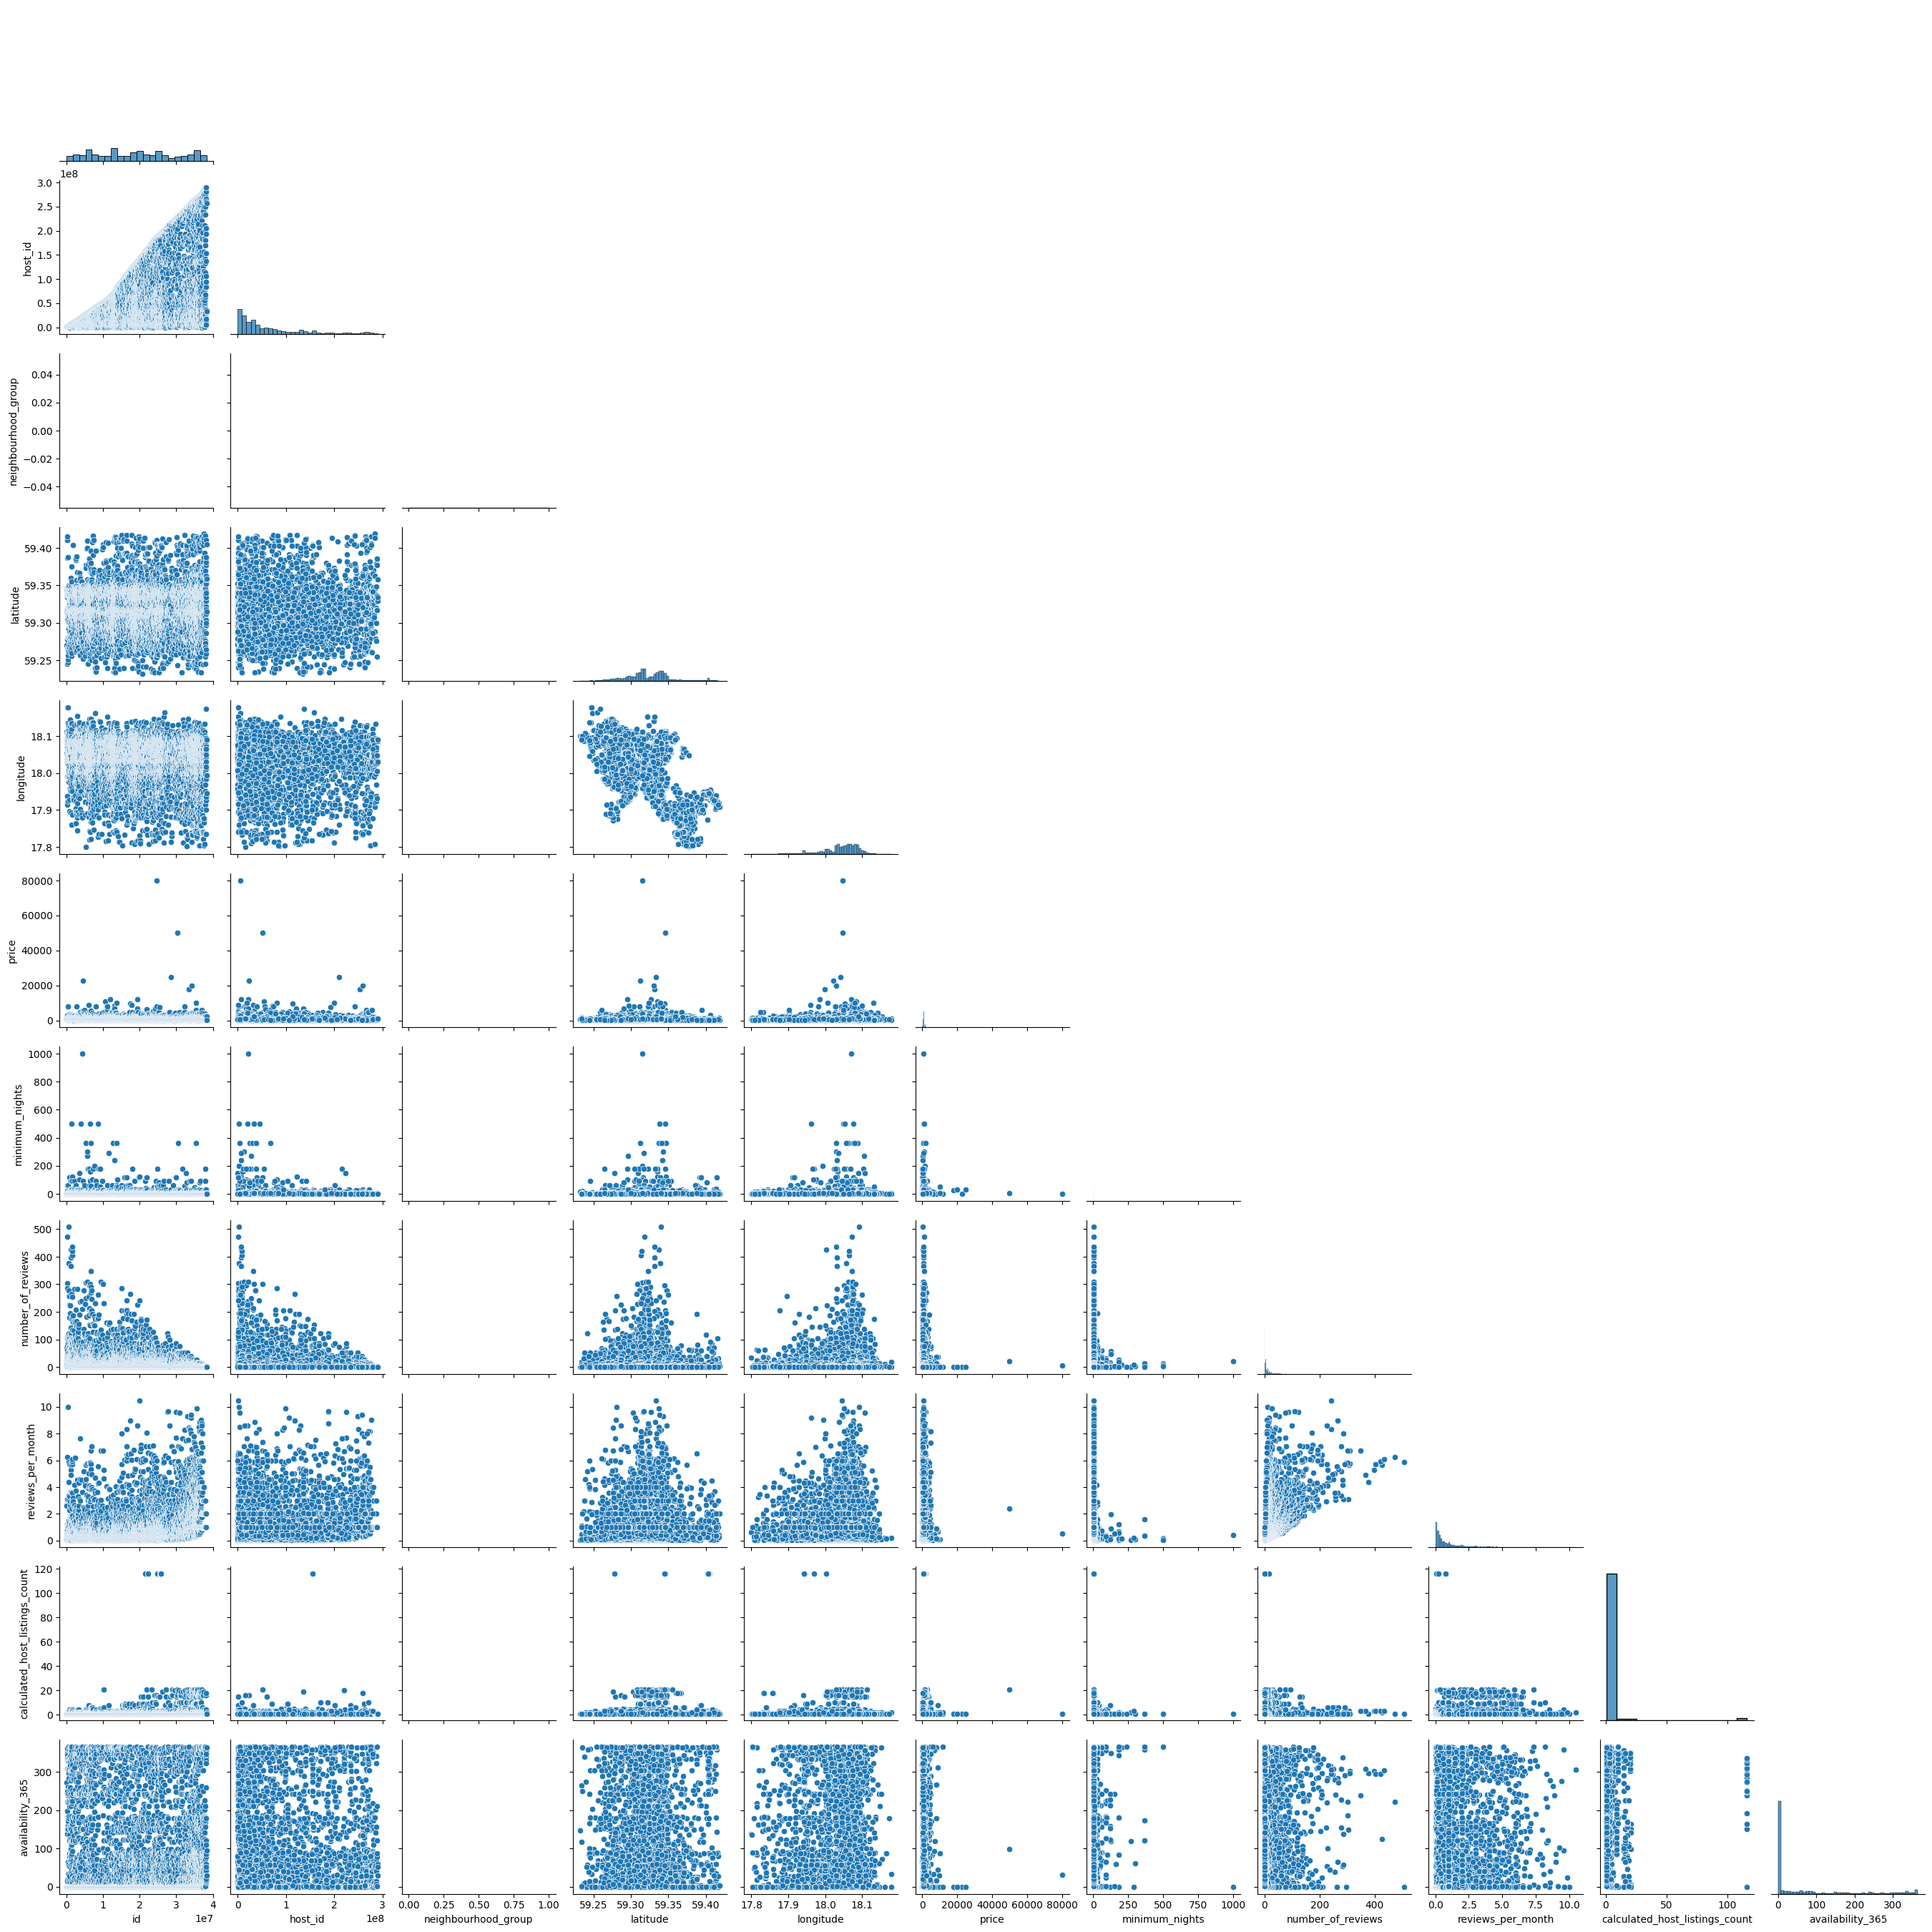

In [3]:
sns.pairplot(df_raw, corner = True)
#plt.savefig('figure/pairplot_raw.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)

In [4]:
df_raw.isnull().sum(), df_raw.shape

(id                                   0
 name                                25
 host_id                              0
 host_name                            8
 neighbourhood_group               7854
 neighbourhood                        0
 latitude                             0
 longitude                            0
 room_type                            0
 price                                0
 minimum_nights                       0
 number_of_reviews                    0
 last_review                       1581
 reviews_per_month                 1581
 calculated_host_listings_count       0
 availability_365                     0
 dtype: int64,
 (7854, 16))

In [5]:
df_raw_dropcol = df_raw.drop(['id', 'host_id', 'host_name', 'neighbourhood_group'], axis = 1)
df_raw_dropcol.isnull().sum(), df_raw_dropcol.shape

(name                                25
 neighbourhood                        0
 latitude                             0
 longitude                            0
 room_type                            0
 price                                0
 minimum_nights                       0
 number_of_reviews                    0
 last_review                       1581
 reviews_per_month                 1581
 calculated_host_listings_count       0
 availability_365                     0
 dtype: int64,
 (7854, 12))

In [6]:
df_raw_dropcol_droprow = df_raw_dropcol.dropna()
df_raw_dropcol_droprow.isnull().sum(), df_raw_dropcol_droprow.shape

(name                              0
 neighbourhood                     0
 latitude                          0
 longitude                         0
 room_type                         0
 price                             0
 minimum_nights                    0
 number_of_reviews                 0
 last_review                       0
 reviews_per_month                 0
 calculated_host_listings_count    0
 availability_365                  0
 dtype: int64,
 (6262, 12))

In [7]:
df_raw_dropcol_droprow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6262 entries, 0 to 7832
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            6262 non-null   object 
 1   neighbourhood                   6262 non-null   object 
 2   latitude                        6262 non-null   float64
 3   longitude                       6262 non-null   float64
 4   room_type                       6262 non-null   object 
 5   price                           6262 non-null   int64  
 6   minimum_nights                  6262 non-null   int64  
 7   number_of_reviews               6262 non-null   int64  
 8   last_review                     6262 non-null   object 
 9   reviews_per_month               6262 non-null   float64
 10  calculated_host_listings_count  6262 non-null   int64  
 11  availability_365                6262 non-null   int64  
dtypes: float64(3), int64(5), object(4)

In [8]:
text_columns = ['name']
df_txt = df_raw_dropcol_droprow[text_columns]

encode_columns = ['room_type']
df_num = df_raw_dropcol_droprow.drop(columns = text_columns)
df_num = pd.get_dummies(df_num, columns = ['neighbourhood', 'room_type'], drop_first = False)

df_last_review_timestamp = pd.to_datetime(df_raw_dropcol_droprow['last_review'])
earliest_time = df_last_review_timestamp.min()
time_diff = (df_last_review_timestamp - earliest_time).dt.days
df_num['last_review'] = time_diff
df_num = df_num.astype(float)

df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6262 entries, 0 to 7832
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   latitude                              6262 non-null   float64
 1   longitude                             6262 non-null   float64
 2   price                                 6262 non-null   float64
 3   minimum_nights                        6262 non-null   float64
 4   number_of_reviews                     6262 non-null   float64
 5   last_review                           6262 non-null   float64
 6   reviews_per_month                     6262 non-null   float64
 7   calculated_host_listings_count        6262 non-null   float64
 8   availability_365                      6262 non-null   float64
 9   neighbourhood_Bromma                  6262 non-null   float64
 10  neighbourhood_Enskede-Årsta-Vantörs   6262 non-null   float64
 11  neighbourhood_Far

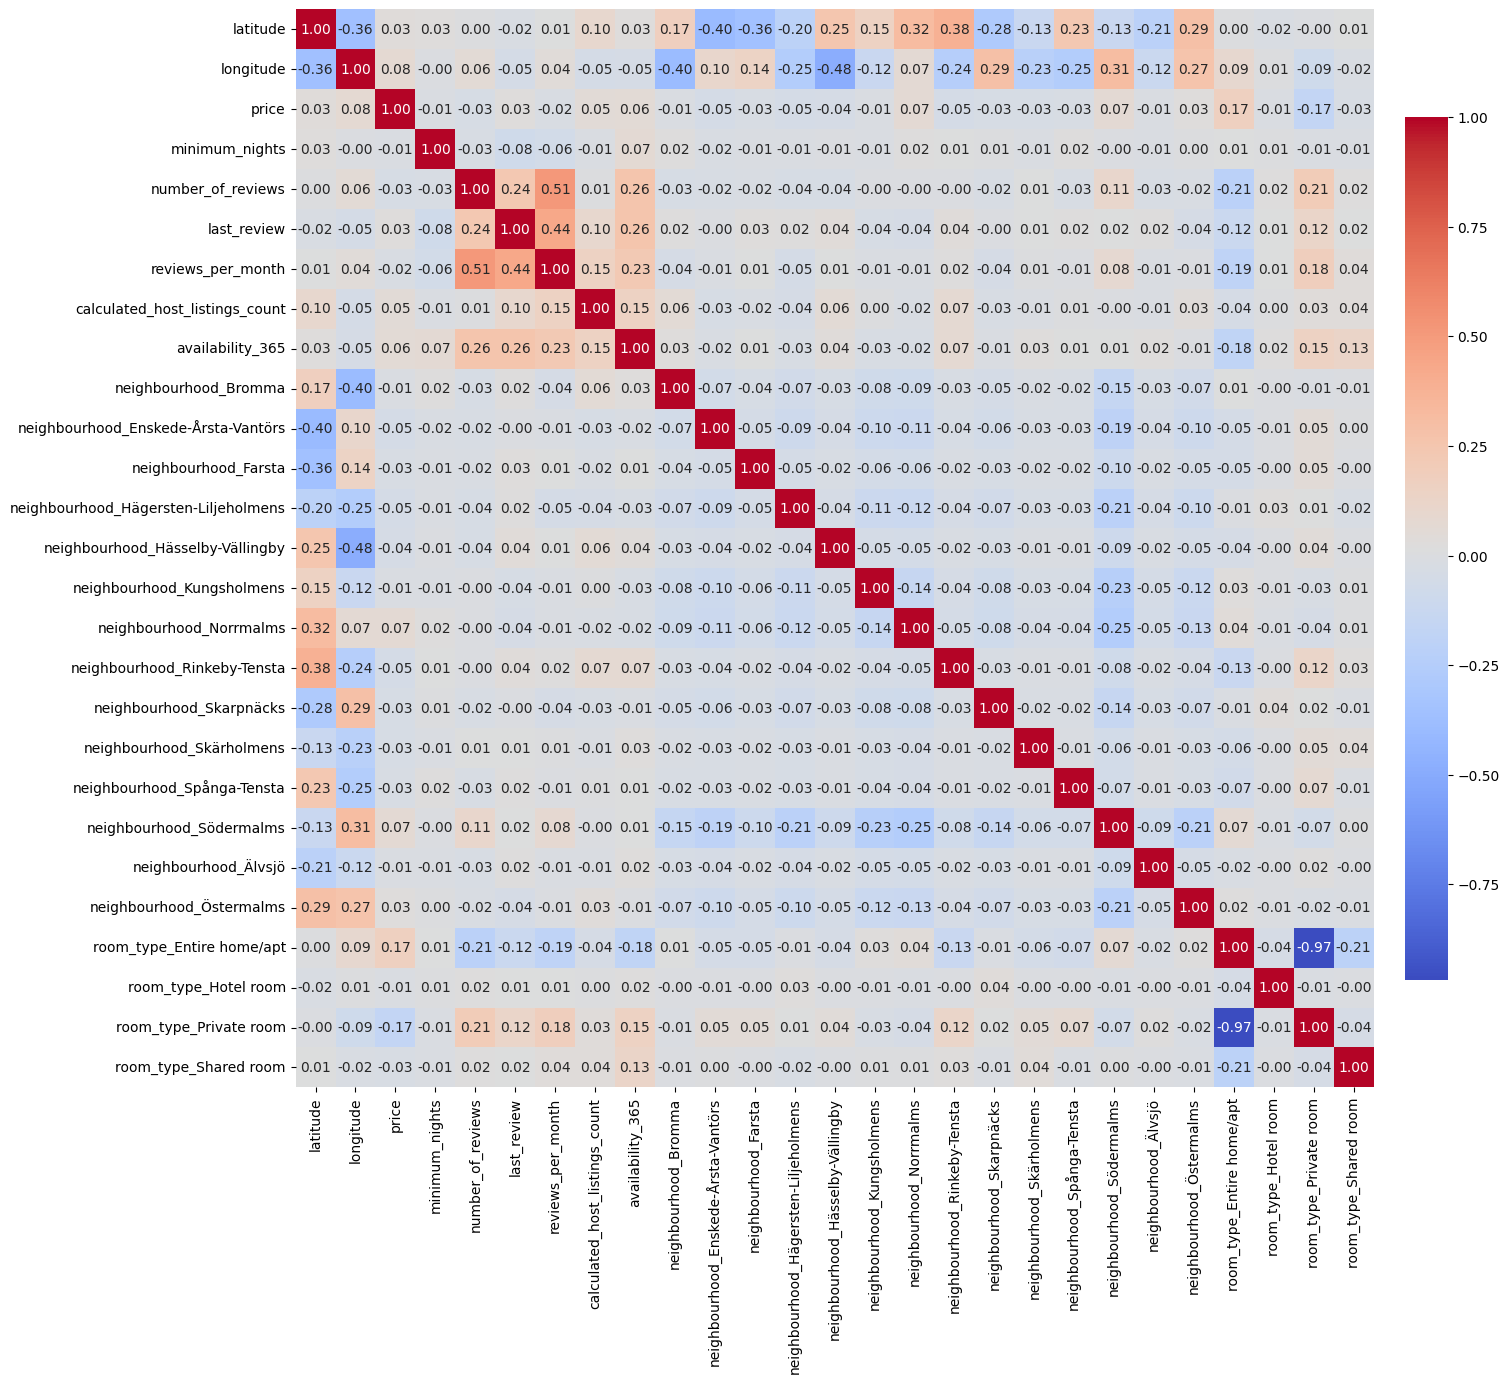

In [9]:
#df_num.corr().style.background_gradient(cmap = 'coolwarm')
corr_matrix = df_num.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True, cbar_kws = {'shrink': 0.8, 'pad': 0.02})
#plt.savefig('figure/correlation_heatmap_before_pca.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

# 2. Principal component analysis (PCA)

## 2.1 Data scaling

In [10]:
x = pd.DataFrame(StandardScaler().fit_transform(df_num))
x.columns = [f'{c} (scaled)' for c in df_num.columns]
x.head()

latitude (scaled)  longitude (scaled)  price (scaled)  \
0           0.868854            0.234301       -0.165815   
1          -1.830652            1.318663       -0.001818   
2          -0.234210            0.226625        0.147666   
3          -0.170870           -0.135073        1.571390   
4          -0.269768            0.409758       -0.350855   

   minimum_nights (scaled)  number_of_reviews (scaled)  last_review (scaled)  \
0                -0.172593                    1.227592              0.764242   
1                -0.082110                   -0.331563             -1.128021   
2                -0.127351                    1.446421              0.616913   
3                -0.036868                    0.078741             -2.380321   
4                -0.082110                    7.792457              0.761940   

   reviews_per_month (scaled)  calculated_host_listings_count (scaled)  \
0                   -0.326764                                -0.177170   
1                   -0.681501                                -0.177170   
2                    1.092183                                -0.177170   
3                   -0.570211                                -0.177170   
4                    1.419097                                 0.063228   

   availability_365 (scaled)  neighbourhood_Bromma (scaled)  ...  \
0                   1.888809                      -0.223532  ...   
1                  -0.601619                      -0.223532  ...   
2                  -0.601619                      -0.223532  ...   
3                  -0.601619                      -0.223532  ...   
4                   0.762622                      -0.223532  ...   

   neighbourhood_Skarpnäcks (scaled)  neighbourhood_Skärholmens (scaled)  \
0                          -0.219165                           -0.097527   
1                           4.562764                           -0.097527   
2                          -0.219165                           -0.097527   
3                          -0.219165                           -0.097527   
4                          -0.219165                           -0.097527   

   neighbourhood_Spånga-Tensta (scaled)  neighbourhood_Södermalms (scaled)  \
0                             -0.100811                          -0.655998   
1                             -0.100811                          -0.655998   
2                             -0.100811                           1.524395   
3                             -0.100811                           1.524395   
4                             -0.100811                           1.524395   

   neighbourhood_Älvsjö (scaled)  neighbourhood_Östermalms (scaled)  \
0                      -0.138585                          -0.326429   
1                      -0.138585                          -0.326429   
2                      -0.138585                          -0.326429   
3                      -0.138585                          -0.326429   
4                      -0.138585                          -0.326429   

   room_type_Entire home/apt (scaled)  room_type_Hotel room (scaled)  \
0                           -2.155581                      -0.017874   
1                           -2.155581                      -0.017874   
2                           -2.155581                      -0.017874   
3                            0.463912                      -0.017874   
4                           -2.155581                      -0.017874   

   room_type_Private room (scaled)  room_type_Shared room (scaled)  
0                         2.227961                       -0.095844  
1                         2.227961                       -0.095844  
2                         2.227961                       -0.095844  
3                        -0.448841                       -0.095844  
4                         2.227961                       -0.095844  

[5 rows x 27 columns]

In [11]:
x_train, x_test = train_test_split(x, test_size = 0.2, random_state = 42)

### 2.2.1 Reduced PCA with 1 component, fit with Gaussian mixture model (GMM)

In [12]:
pca_n1 = PCA(n_components = 1)
reduced_pca_n1 = pca_n1.fit_transform(x)

GMM = GaussianMixture(n_components = 4, random_state = 0)
GMM.fit(reduced_pca_n1)

GaussianMixture(n_components=4, random_state=0)

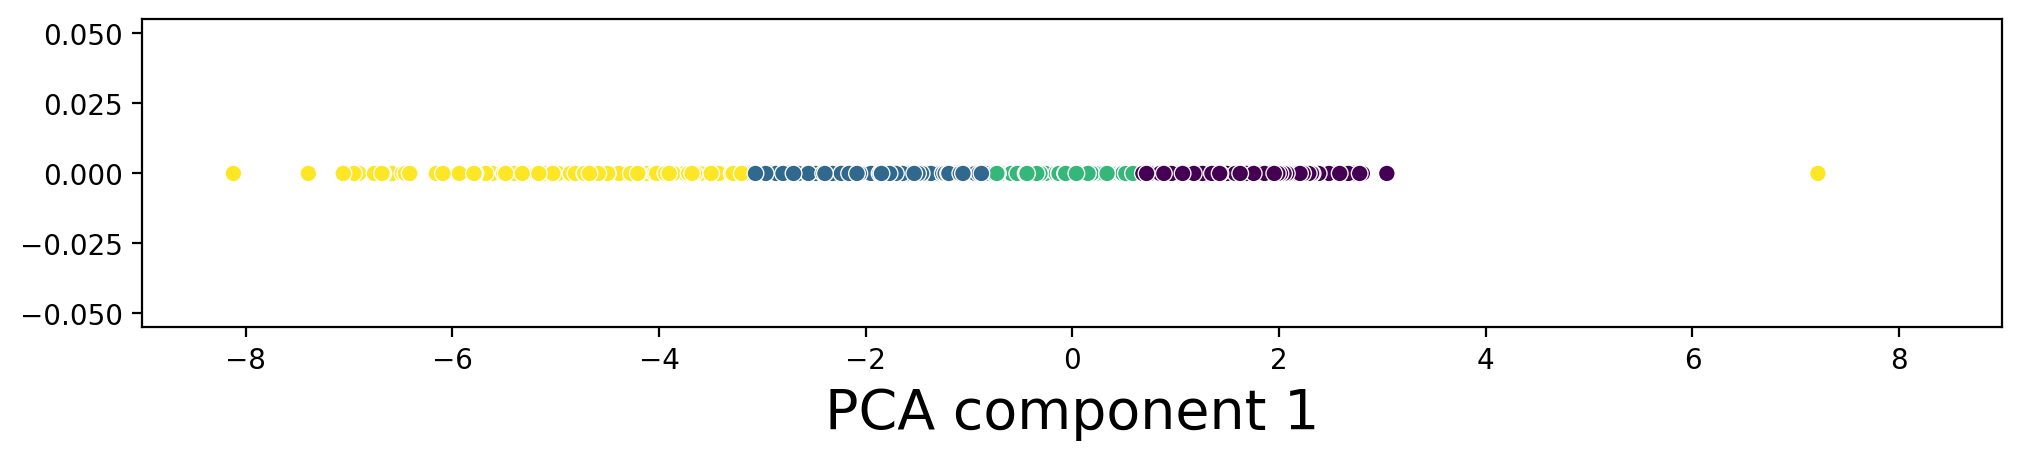

In [13]:
xhat_n1 = GMM.predict(reduced_pca_n1)

plt.figure(figsize = (12, 2), dpi = 200)
sns.scatterplot(x = reduced_pca_n1.flatten(), y = np.zeros(len(xhat_n1)), c = xhat_n1)
#plt.title('1D projection of the clusters', fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 20)
plt.xlim(-9, 9)
#plt.savefig('figure/reduced_pca_n1.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

### 2.2.2 Reduced PCA with 2 components, fit with GMM

In [14]:
pca_n2 = PCA(n_components = 2)
reduced_pca_n2 = pca_n2.fit_transform(x)

GMM = GaussianMixture(n_components = 4, random_state = 0)
GMM.fit(reduced_pca_n2)

GaussianMixture(n_components=4, random_state=0)

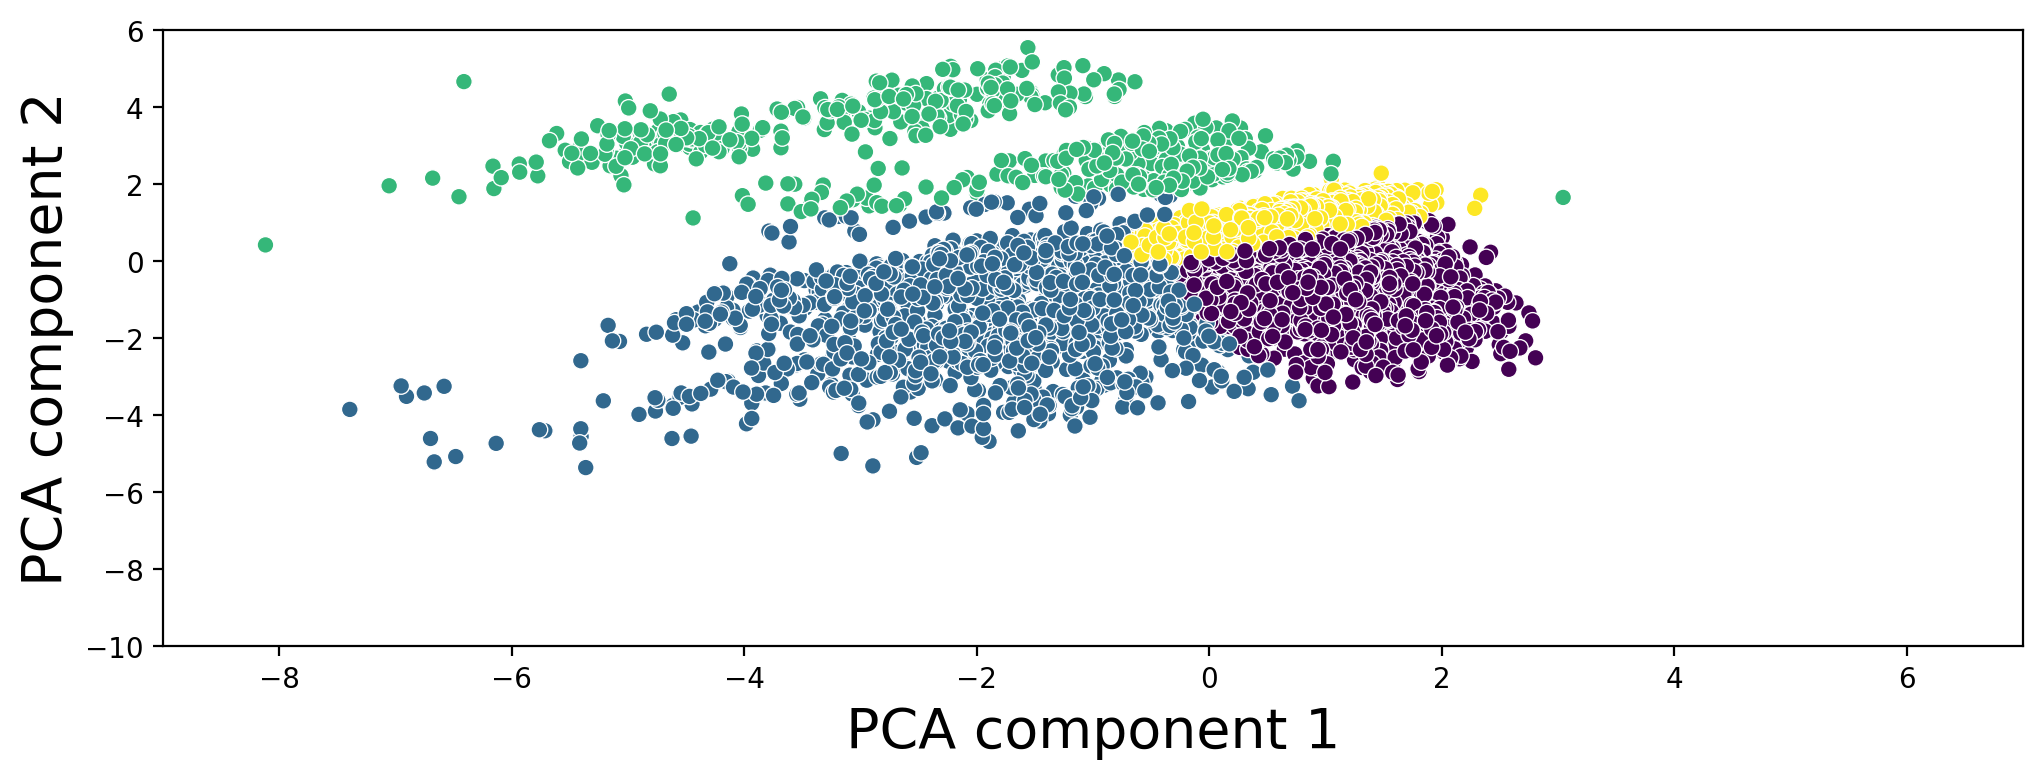

In [15]:
xhat_n2 = GMM.predict(reduced_pca_n2)

plt.figure(figsize = (12, 4), dpi = 200)
sns.scatterplot(x = reduced_pca_n2[:,0], y = reduced_pca_n2[:,1], c = xhat_n2)
#plt.title('2D projection of the clusters', fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 20)
plt.ylabel('PCA component 2', fontsize = 20)
plt.xlim(-9, 7)
plt.ylim(-10, 6)
#plt.savefig('figure/reduced_pca_n2.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

### 2.2.3 Reduced PCA with 3 components

In [16]:
pca_n3 = PCA(n_components = 3)
reduced_pca_n3 = pca_n3.fit_transform(x)

GMM.fit(reduced_pca_n3)

GaussianMixture(n_components=4, random_state=0)

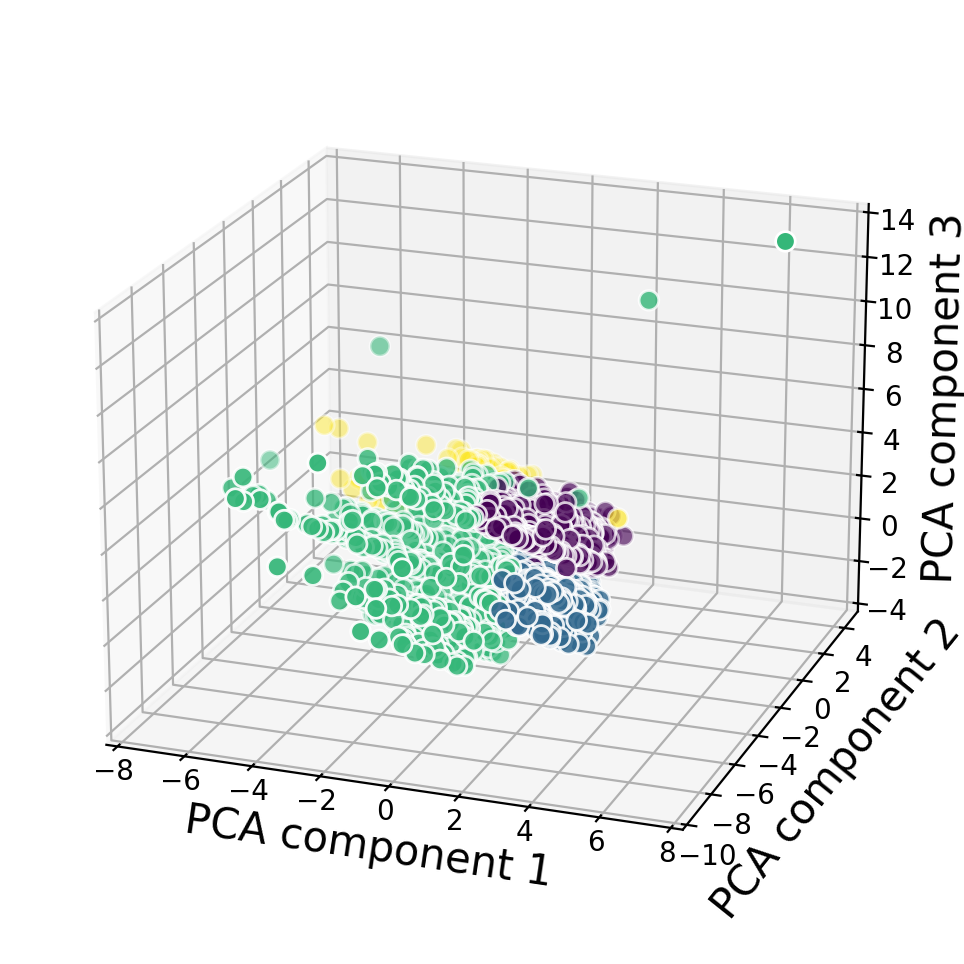

In [17]:
xhat_n3 = GMM.predict(reduced_pca_n3)
reduced_pca_n3 = pd.DataFrame(reduced_pca_n3, columns = (['PCA component 1', 'PCA component 2', 'PCA component 3']))

fig = plt.figure(figsize = (12, 6), dpi = 200)
ax = fig.add_subplot(111, projection = '3d')
#ax.set_title('3D projection of the clusters', fontsize = 15)
ax.scatter(reduced_pca_n3['PCA component 1'], reduced_pca_n3['PCA component 2'], reduced_pca_n3['PCA component 3'], c = xhat_n3, edgecolor = 'white', s = 50)
ax.set_xlim(-8, 8)
ax.set_ylim(-10, 5)
ax.set_zlim(-4, 14)
ax.tick_params(axis = 'x', labelsize = 10, pad = -5)
ax.tick_params(axis = 'y', labelsize = 10, pad = -2)
ax.tick_params(axis = 'z', labelsize = 10, pad = -1)
ax.set_xlabel('PCA component 1', fontsize = 15, labelpad = -5)
ax.set_ylabel('PCA component 2', fontsize = 15, labelpad = -2)
ax.set_zlabel('PCA component 3', fontsize = 15, labelpad = -1)
ax.view_init(elev = 20, azim = -70)
#plt.savefig('figure/reduced_pca_n3.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

### 2.2.4 Full PCA

In [18]:
pca = PCA()
pca.fit(x)

PCA()

In [19]:
xhat = pca.transform(x)
xhat.shape

(6262, 27)

In [20]:
df_pca = pd.DataFrame(columns = [f'component {i+1}' for i in range(len(df_num.columns))], data = xhat)
df_pca.head()

component 1  component 2  component 3  component 4  component 5  \
0    -3.025562    -0.586741     0.463778     1.838570    -0.819844   
1    -0.065778    -2.694108    -2.450575     2.700243    -0.114881   
2    -2.424074    -2.072617     0.218254     0.683546     1.746879   
3     1.740293     0.275207     0.299966     0.110836     1.921934   
4    -4.765345    -3.885590     2.193492    -0.357645     1.233942   

   component 6  component 7  component 8  component 9  component 10  ...  \
0     1.366886     1.982761     0.244164    -0.045603     -0.003733  ...   
1    -0.678255     0.324346    -0.225214    -2.468019     -1.632867  ...   
2     0.834891    -0.174697    -0.270248     0.257544     -0.212025  ...   
3    -0.054432     0.331445     0.305544     0.067664      0.280534  ...   
4     2.074045    -0.565511    -0.339461    -0.061361     -0.332346  ...   

   component 18  component 19  component 20  component 21  component 22  \
0     -0.524646      0.594751     -0.217127      1.372277      0.912242   
1     -1.303402      1.060749     -0.480018     -0.202993     -0.795603   
2     -0.366440      0.679671     -0.167720     -0.928623     -0.295235   
3     -0.142711      1.041922     -0.582437      0.322842     -1.764223   
4     -0.094848     -0.334367     -0.284338      0.996255     -3.335896   

   component 23  component 24  component 25  component 26  component 27  
0     -0.793703      0.047536      0.022278 -3.526254e-15  8.112257e-16  
1      0.134010     -0.184890     -0.337342 -4.414433e-15  2.754116e-15  
2     -0.261316     -0.202681      0.008159 -3.748299e-15 -9.234978e-16  
3      0.355827     -0.443232      0.084397  3.734041e-16 -2.245574e-15  
4     -3.379218     -0.081748     -0.085170 -2.860120e-15  1.867252e-16  

[5 rows x 27 columns]

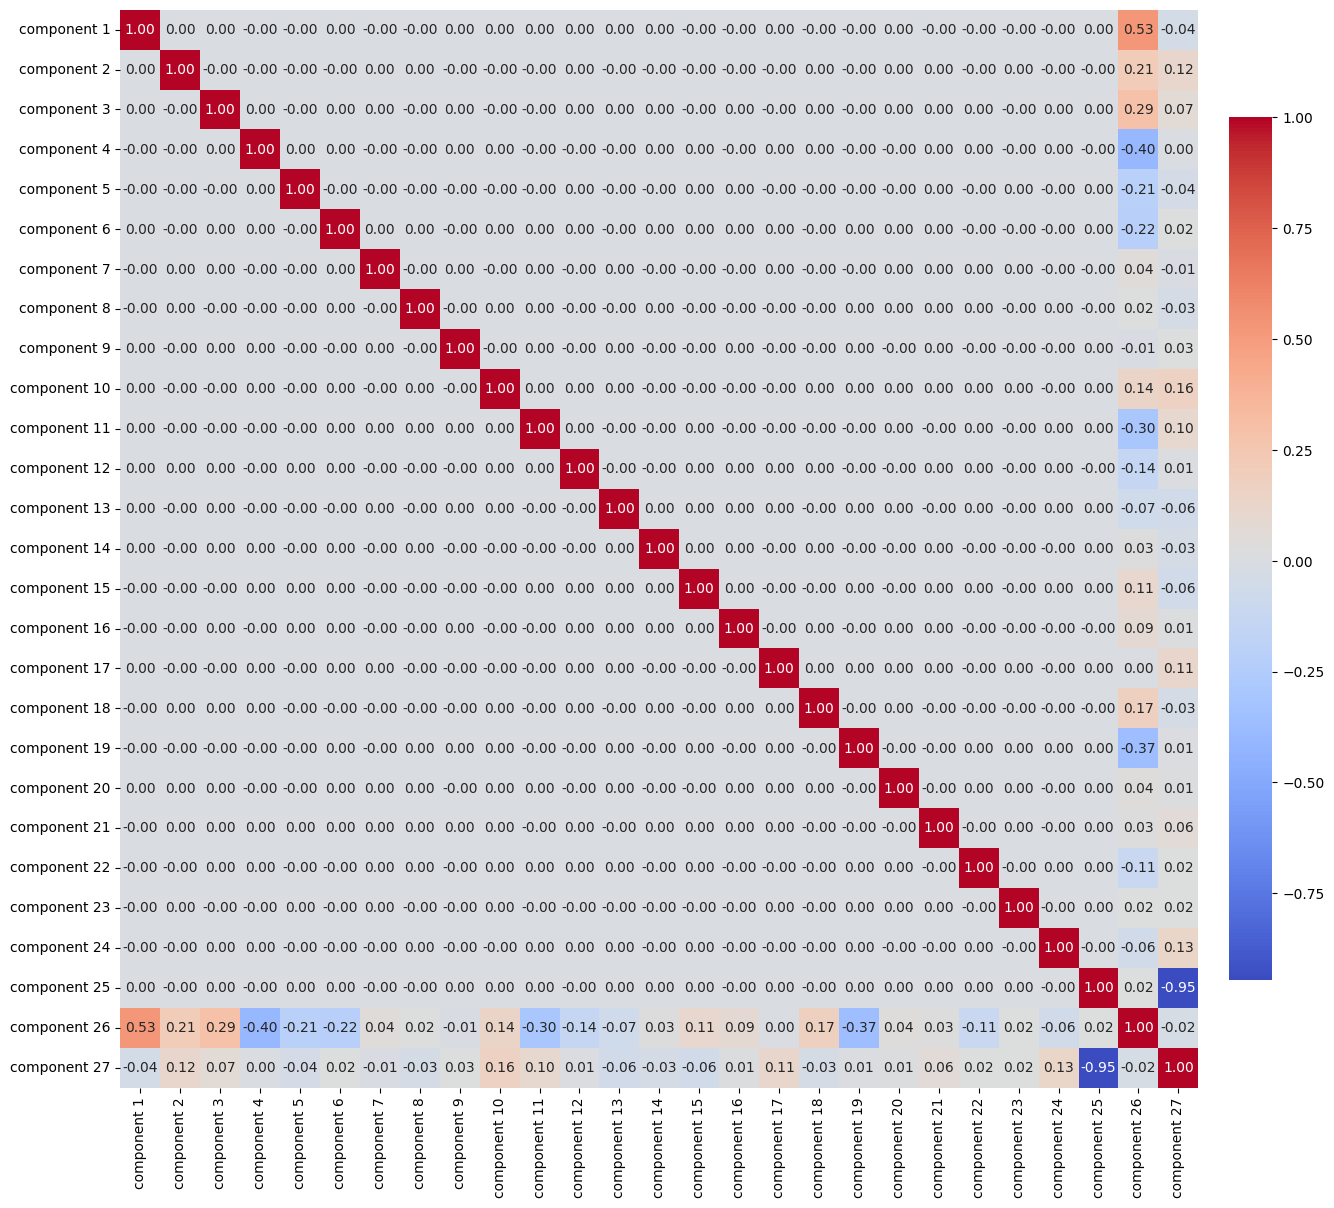

In [21]:
#df_pca.corr().style.background_gradient(cmap = 'coolwarm')
corr_matrix = df_pca.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True, cbar_kws = {'shrink': 0.8, 'pad': 0.02})
#plt.savefig('figure/correlation_heatmap_after_pca.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

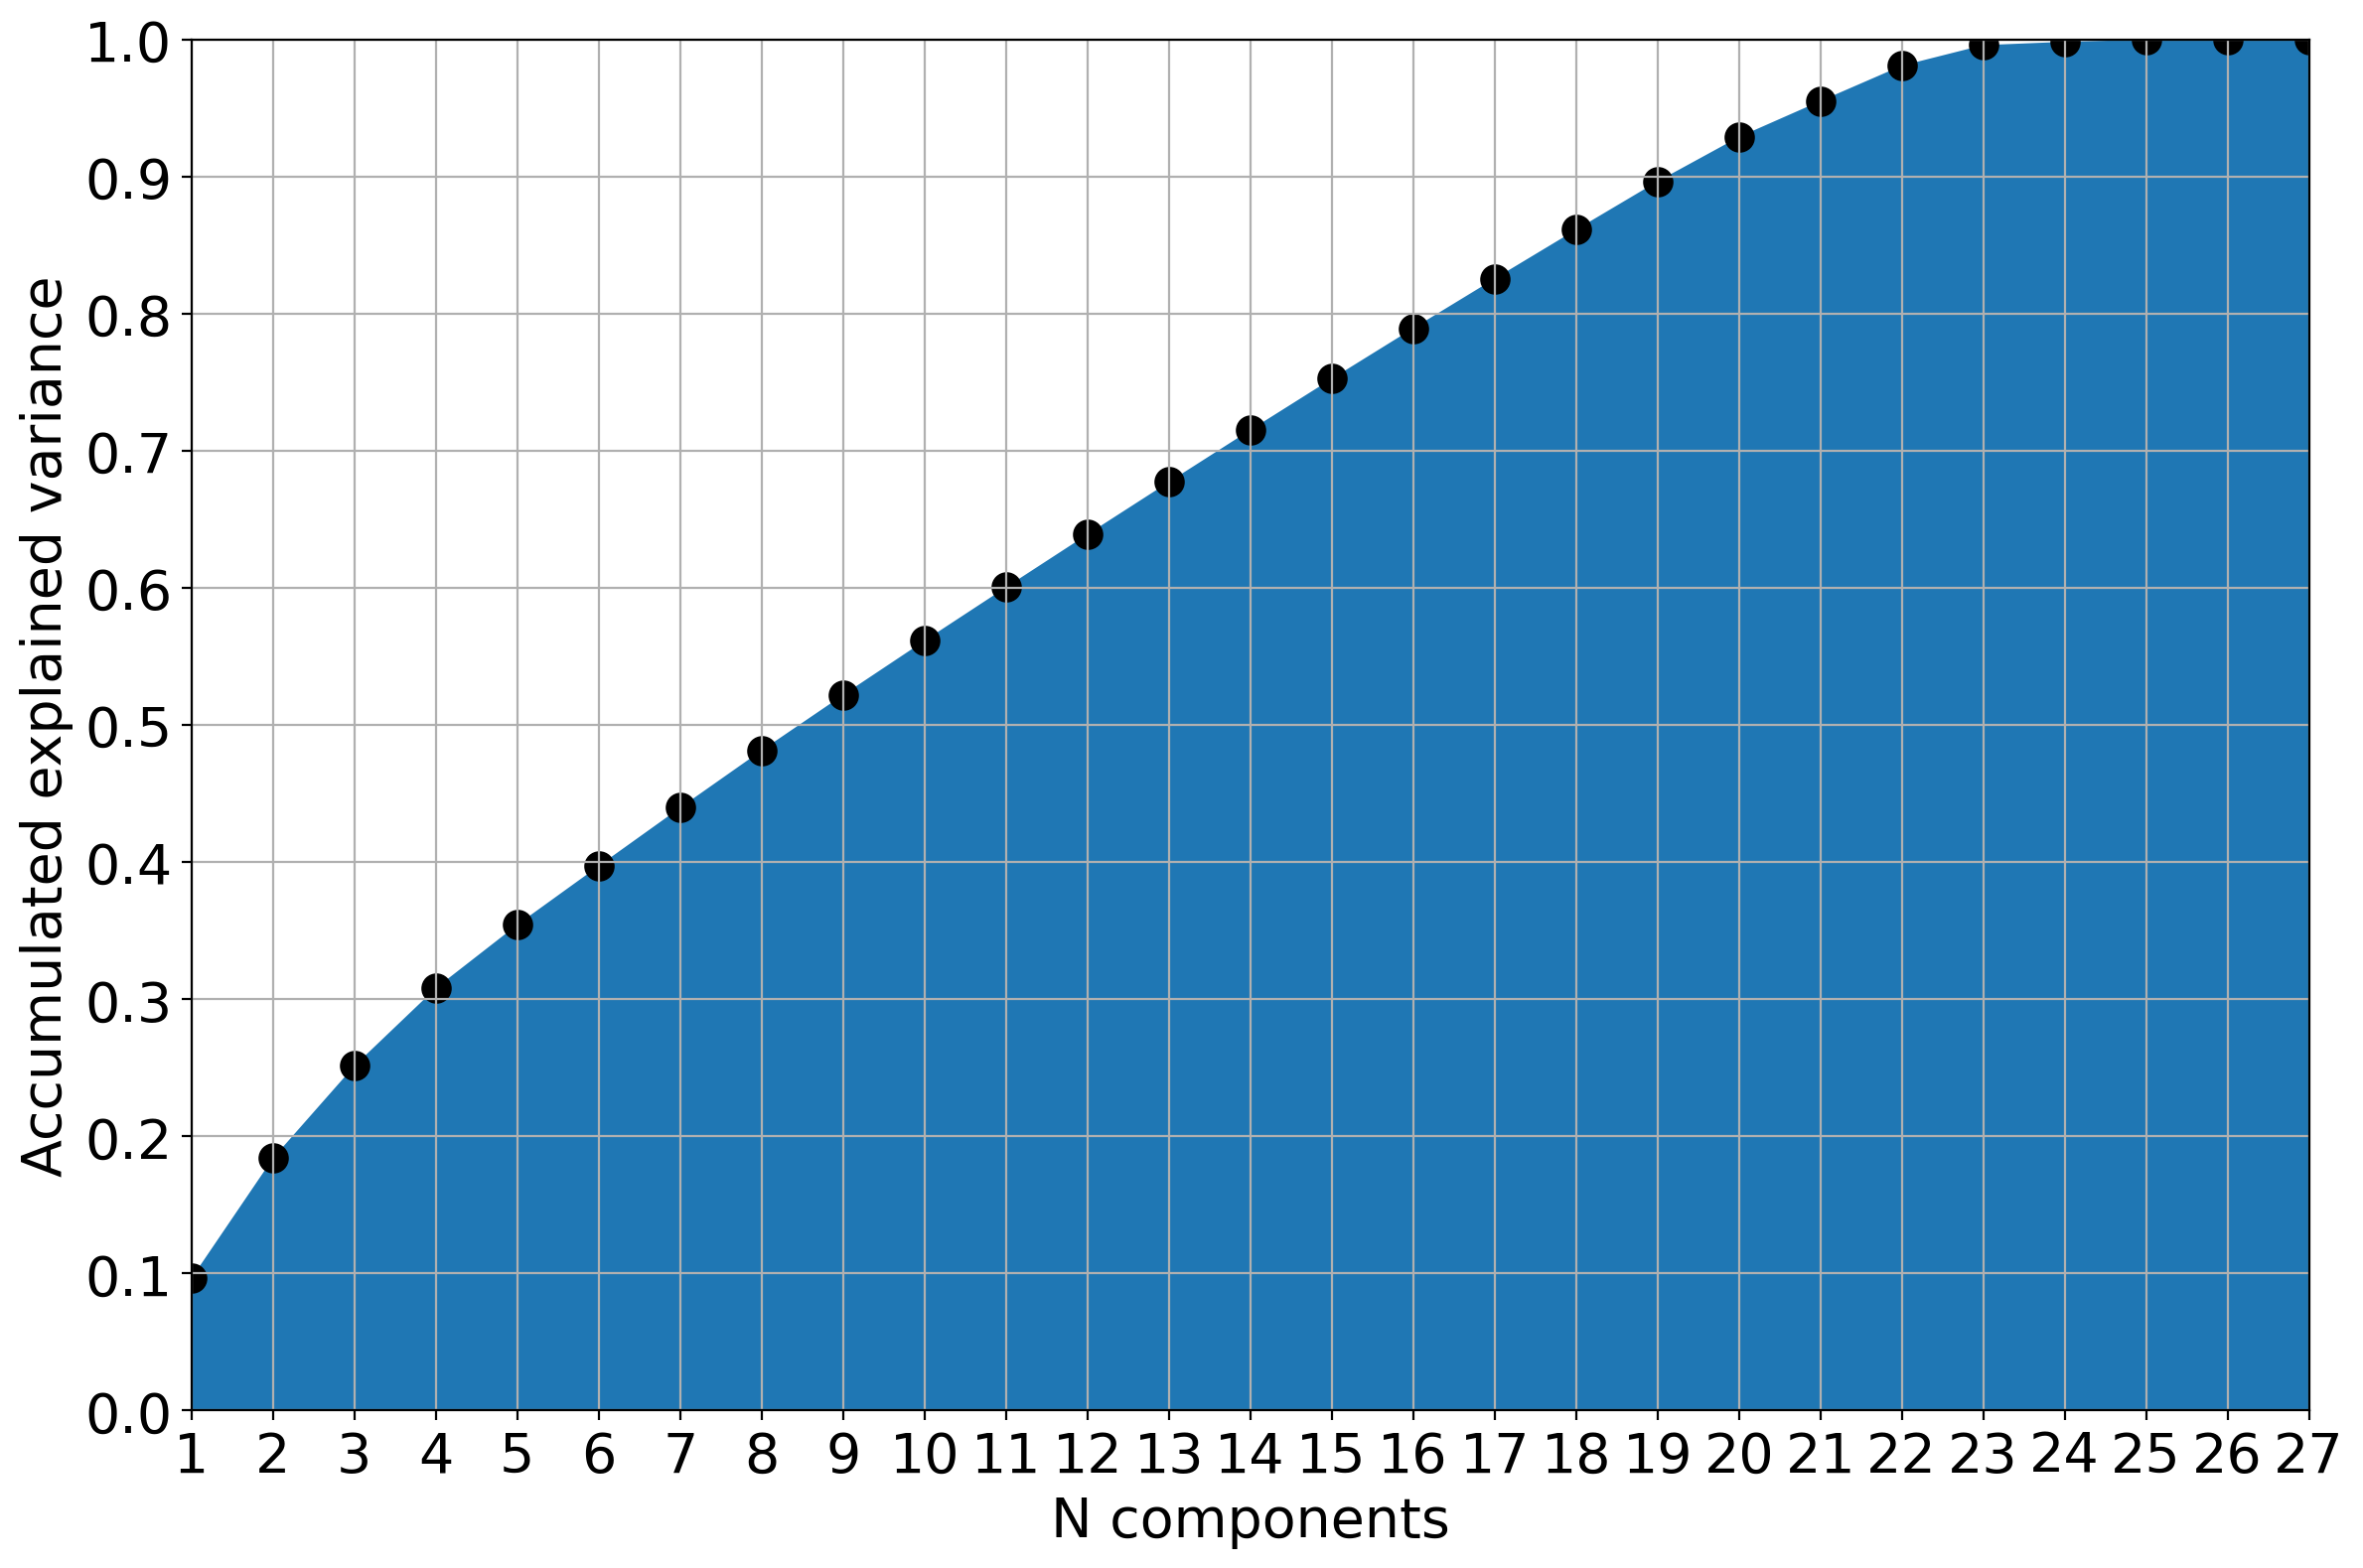

In [22]:
def plot_explained_variance(pca):
    # This function graphs the accumulated explained variance ratio for a fitted PCA object.
    acc = [*accumulate(pca.explained_variance_ratio_)]
    N = pca.n_components_
    #Nran = range(N)
    Nran = range(1, N + 1)
    plt.figure(figsize = (12, 8), dpi = 200)
    plt.stackplot(Nran, acc)
    plt.scatter(Nran, acc, s = 100, fc = 'black')
    plt.ylim(0, 1)
    plt.xlim(1, N)
    plt.xticks(Nran, fontsize = 20)
    plt.yticks(np.linspace(0, 1, 11), fontsize = 20)
    plt.xlabel('N components', fontsize = 20)
    plt.ylabel('Accumulated explained variance', fontsize = 20)
    plt.grid()
    plt.tight_layout()
    #plt.savefig('figure/pca_explained_variance.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    plt.show()
    
plot_explained_variance(pca)

In [23]:
threshold = 0.95
num = next(i for i, x in enumerate(accumulate(pca.explained_variance_ratio_), 1) if x >= threshold)
print(f'To keep >= {100 * threshold}% of the explained variance, we keep the first {num} components and discard the other {pca.n_components_-num}.')

To keep >= 95.0% of the explained variance, we keep the first 21 components and discard the other 6.


In [24]:
df_pca.drop([f'component {i+1}' for i in range(num, pca.n_components_)], axis = 1, inplace = True)
df_pca.head()

component 1  component 2  component 3  component 4  component 5  \
0    -3.025562    -0.586741     0.463778     1.838570    -0.819844   
1    -0.065778    -2.694108    -2.450575     2.700243    -0.114881   
2    -2.424074    -2.072617     0.218254     0.683546     1.746879   
3     1.740293     0.275207     0.299966     0.110836     1.921934   
4    -4.765345    -3.885590     2.193492    -0.357645     1.233942   

   component 6  component 7  component 8  component 9  component 10  ...  \
0     1.366886     1.982761     0.244164    -0.045603     -0.003733  ...   
1    -0.678255     0.324346    -0.225214    -2.468019     -1.632867  ...   
2     0.834891    -0.174697    -0.270248     0.257544     -0.212025  ...   
3    -0.054432     0.331445     0.305544     0.067664      0.280534  ...   
4     2.074045    -0.565511    -0.339461    -0.061361     -0.332346  ...   

   component 12  component 13  component 14  component 15  component 16  \
0     -0.141826      0.041805      0.052691     -0.100930     -0.406052   
1      1.510784      0.813405     -0.253638     -0.953765      0.320165   
2     -0.129125      0.198836     -0.076242     -0.435503     -0.282652   
3     -0.033402     -0.009561      0.133812      0.068927     -0.057281   
4     -1.025707      0.968730     -0.280963     -0.352042     -1.319593   

   component 17  component 18  component 19  component 20  component 21  
0      0.296102     -0.524646      0.594751     -0.217127      1.372277  
1     -1.020695     -1.303402      1.060749     -0.480018     -0.202993  
2      0.419390     -0.366440      0.679671     -0.167720     -0.928623  
3      0.438402     -0.142711      1.041922     -0.582437      0.322842  
4      0.200179     -0.094848     -0.334367     -0.284338      0.996255  

[5 rows x 21 columns]

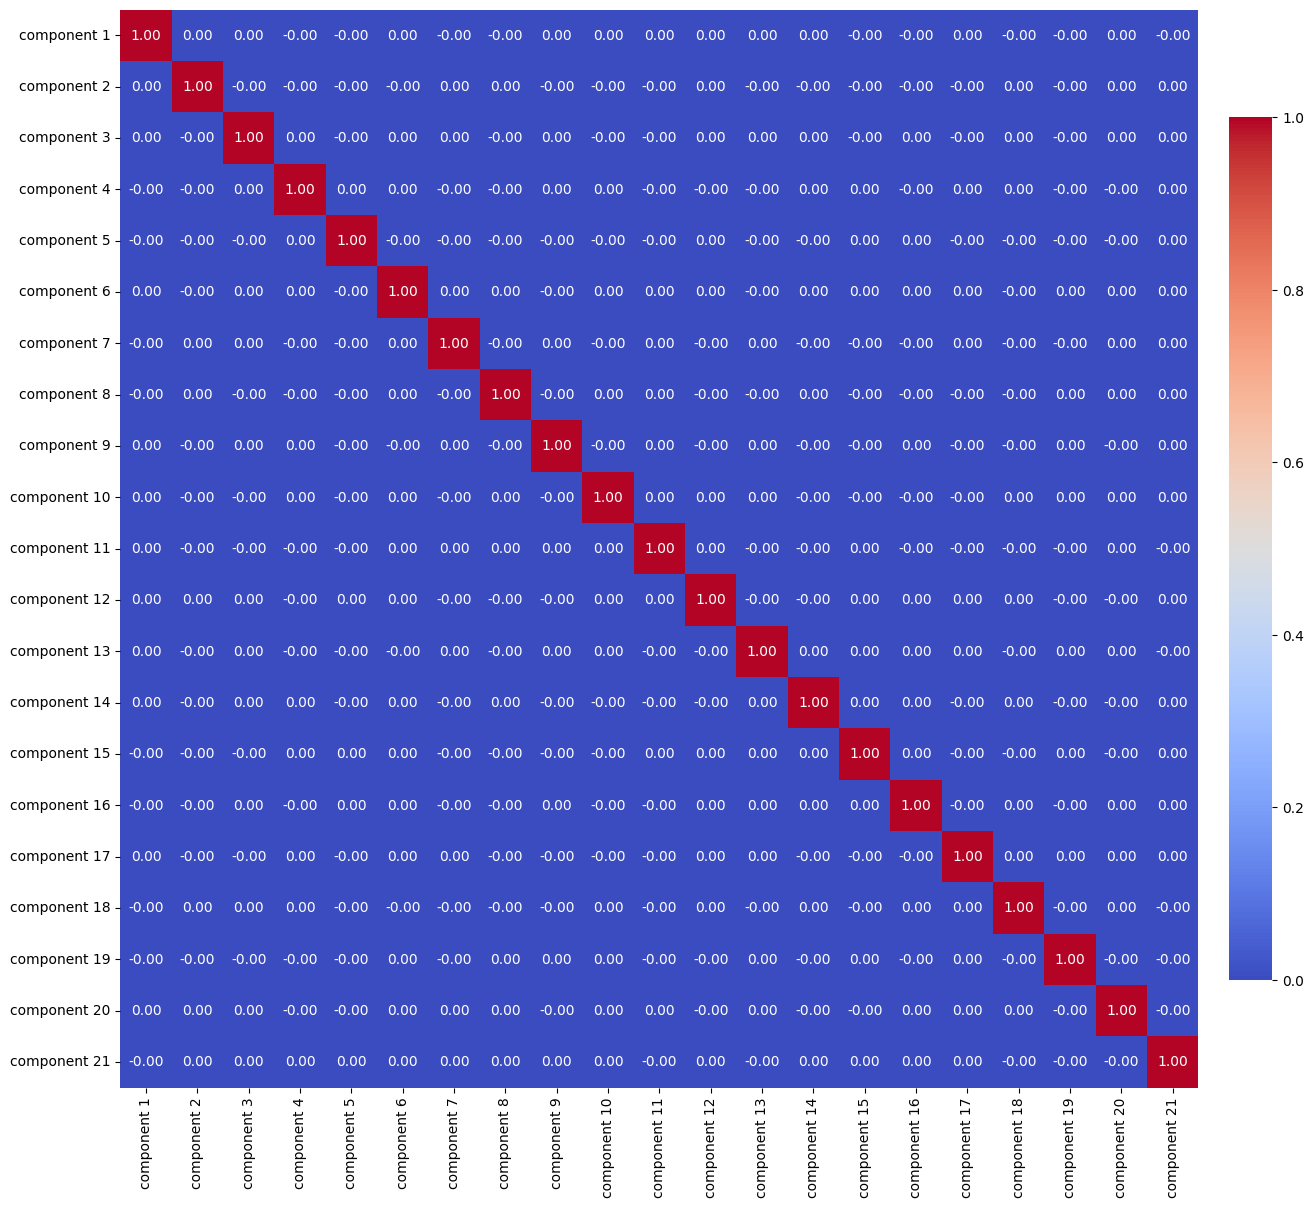

In [25]:
#df_pca.corr().style.background_gradient(cmap = 'coolwarm')
corr_matrix = df_pca.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True, cbar_kws = {'shrink': 0.8, 'pad': 0.02})
#plt.savefig('figure/correlation_heatmap_after_pca2.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

# 3. Clustering models

## 3.1 PCA + K-means

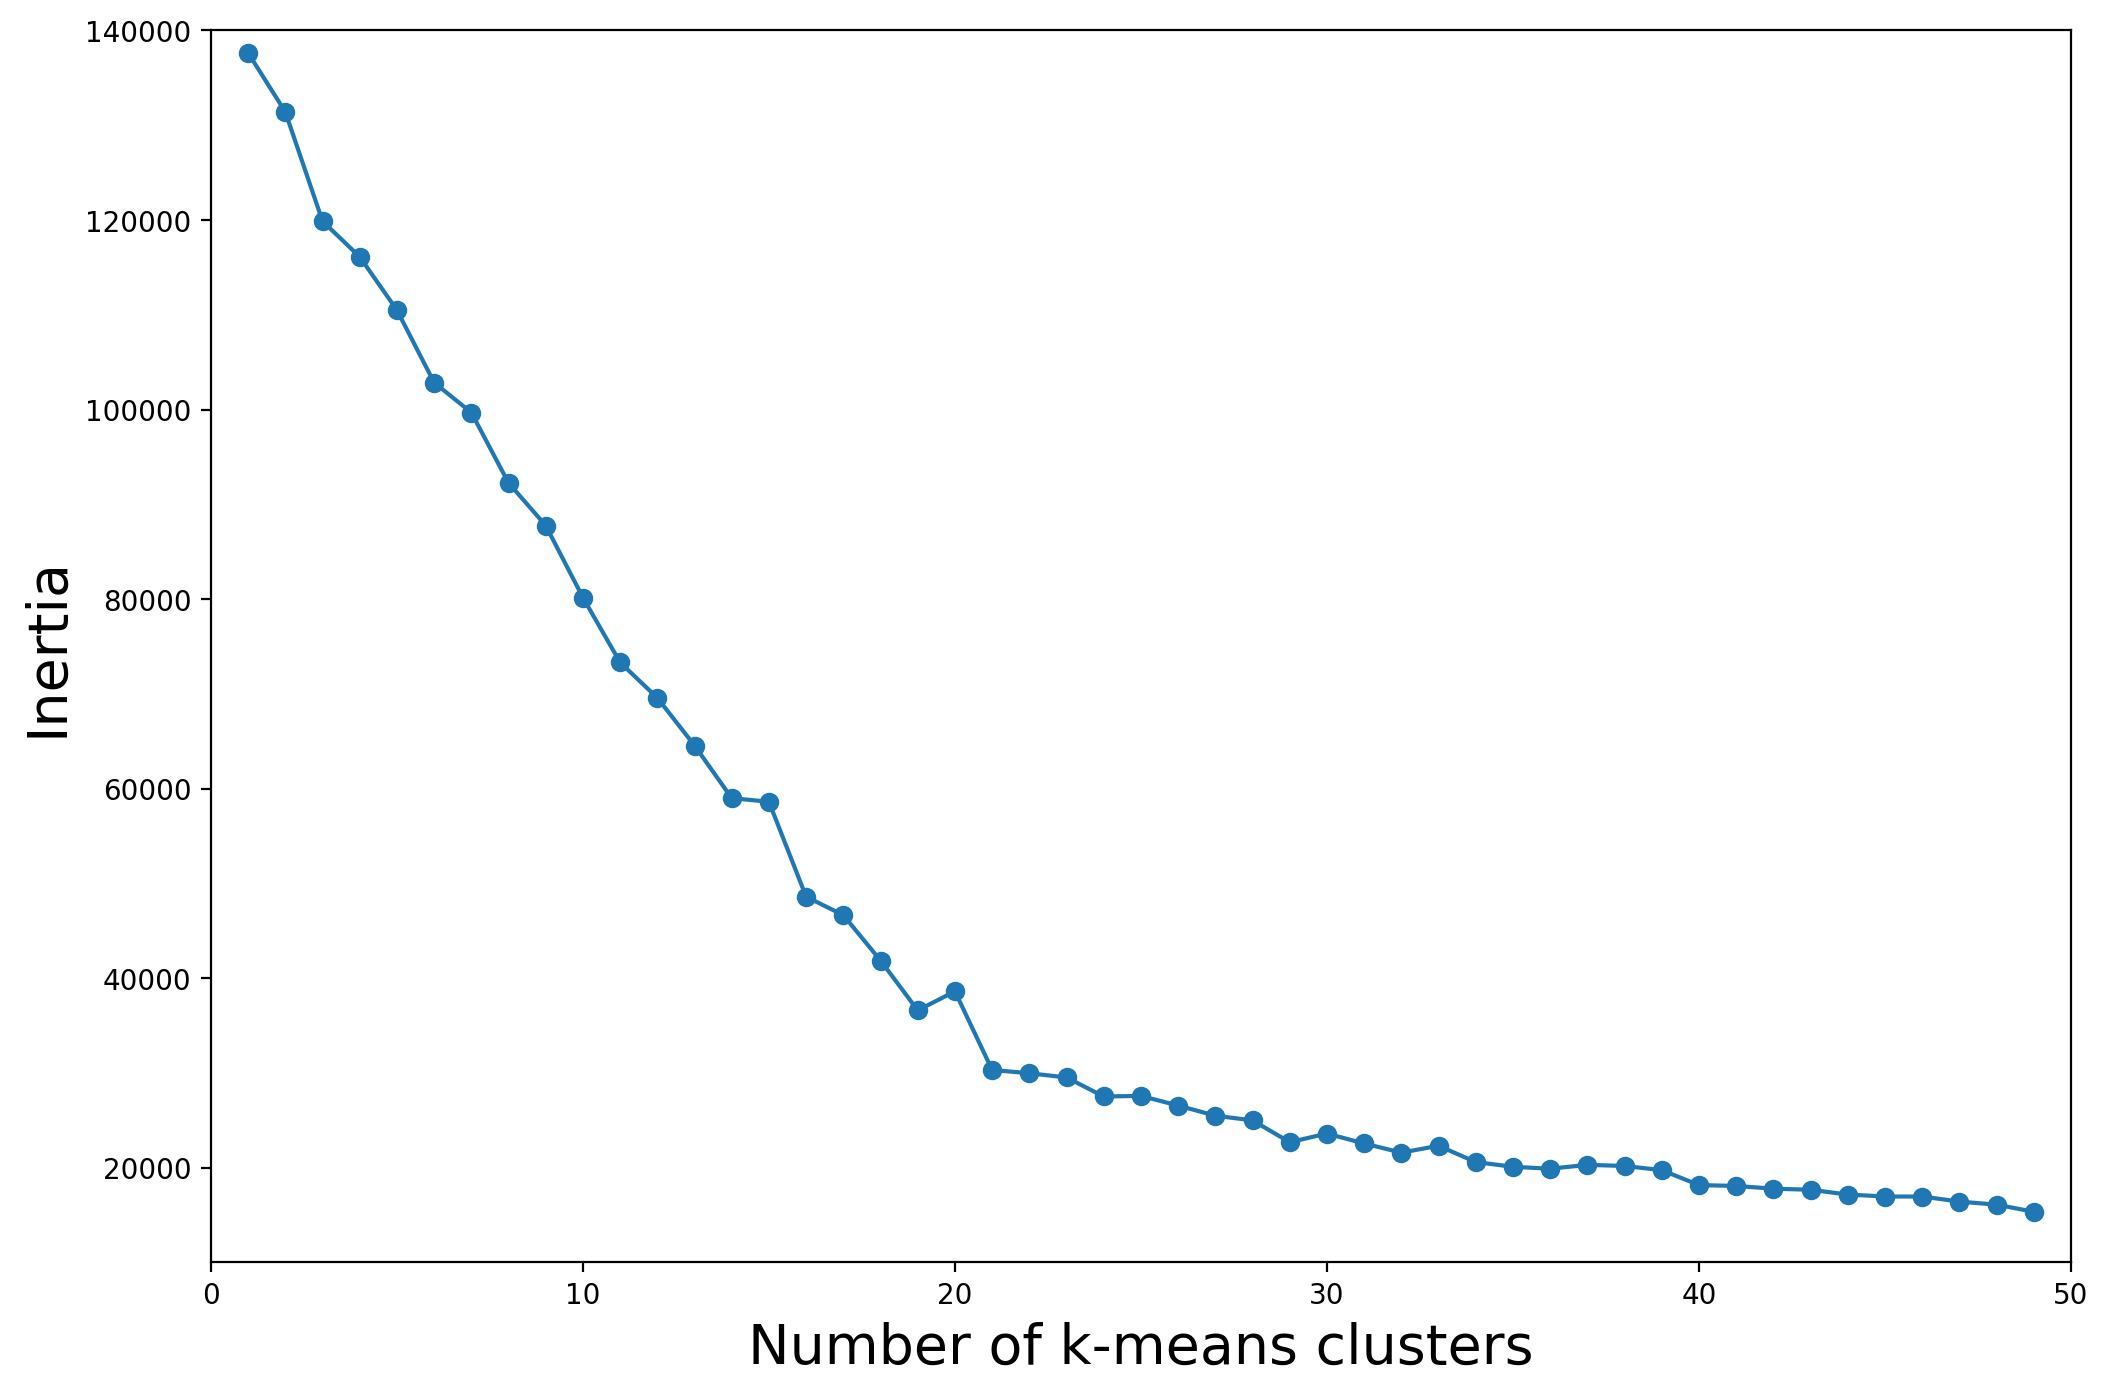

In [26]:
inertia = []
list_num_clusters = list(range(1, 50))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters = num_clusters)
    km.fit(x_train)
    inertia.append(km.inertia_)
    
plt.figure(figsize = (12, 8), dpi = 200)
sns.lineplot(x = list_num_clusters, y = inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel('Number of k-means clusters', fontsize = 20)
plt.ylabel('Inertia', fontsize = 20)
plt.xlim(0, 50)
plt.ylim(1e4, 1.4e5)
#plt.savefig('figure/kmeans_inertia.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

In [27]:
km = KMeans(n_clusters = 20)
km.fit(xhat)

KMeans(n_clusters=20)

In [29]:
#(km.labels_ == km.predict(xhat)).all()

In [30]:
x_pca_km_df = pd.DataFrame(xhat[:,:2], columns = ['x', 'y'])
x_pca_km_df['label'] = km.labels_

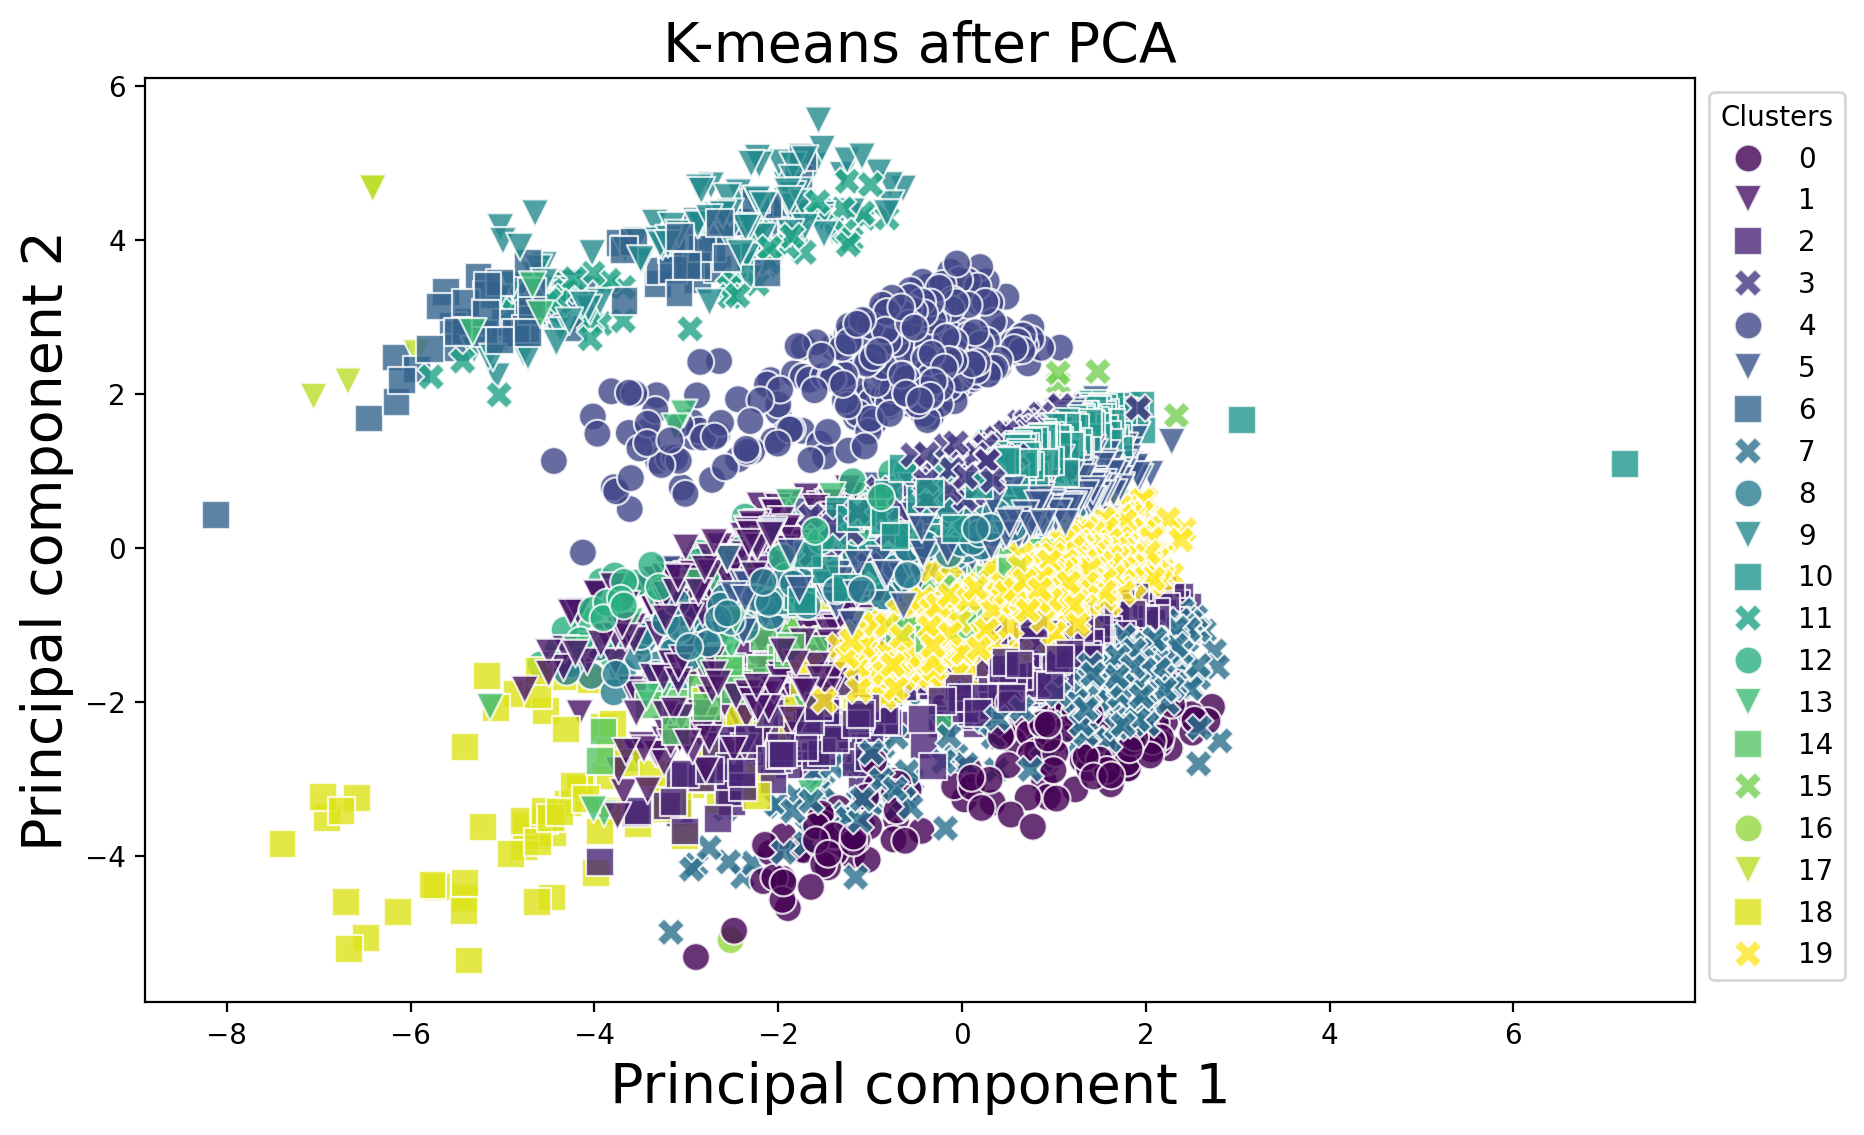

In [31]:
plt.figure(figsize = (10, 6), dpi = 200)
sns.scatterplot(data = x_pca_km_df, x = 'x', y = 'y', hue = 'label', style = 'label', palette = 'viridis',
    markers = ['o', 'v', 's', 'X'], alpha = 0.8, s = 100, legend = 'full')
plt.title('K-means after PCA', fontsize = 20)
plt.xlabel('Principal component 1', fontsize = 20)
plt.ylabel('Principal component 2', fontsize = 20)
plt.legend(title = 'Clusters', bbox_to_anchor = (1, 1), ncol = 1)
#plt.savefig('figure/pca_km.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 3.2 PCA + Meanshift

In [32]:
ms = MeanShift(bandwidth = 8)
ms.fit(xhat)

MeanShift(bandwidth=8)

In [34]:
#(ms.labels_ == ms.predict(xhat)).all()

In [35]:
x_pca_ms_df = pd.DataFrame(xhat[:,:2], columns = ['x', 'y'])
x_pca_ms_df['label'] = ms.labels_

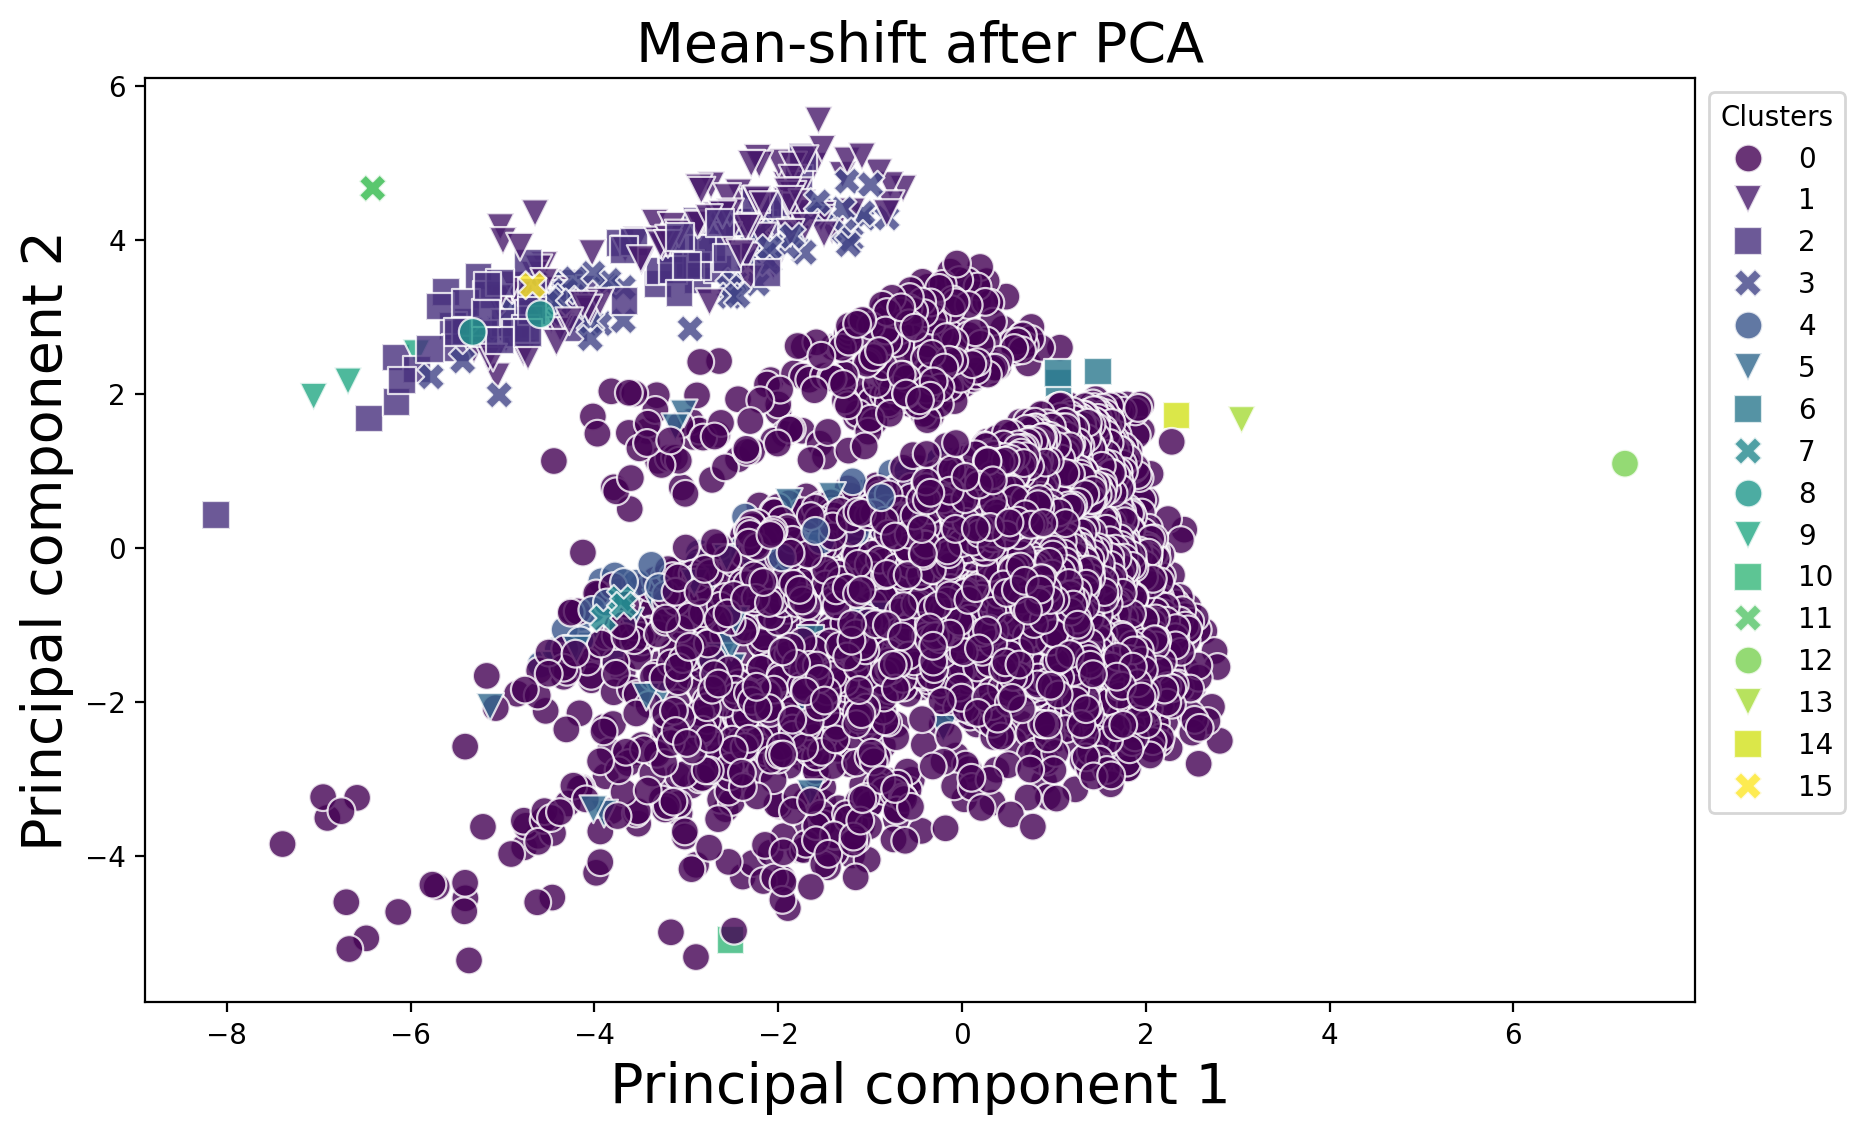

In [36]:
plt.figure(figsize = (10, 6), dpi = 200)
sns.scatterplot(data = x_pca_ms_df, x = 'x', y = 'y', hue = 'label', style = 'label', palette = 'viridis',
    markers = ['o', 'v', 's', 'X'], alpha = 0.8, s = 100, legend = 'full')
plt.title('Mean-shift after PCA', fontsize = 20)
plt.xlabel('Principal component 1', fontsize = 20)
plt.ylabel('Principal component 2', fontsize = 20)
plt.legend(title = 'Clusters', bbox_to_anchor = (1, 1), ncol = 1)
#plt.savefig('figure/pca_ms.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 3.3 PCA + DBSCAN

In [37]:
dbscan = DBSCAN(eps = 2, min_samples = 5)
dbscan.fit(xhat)

DBSCAN(eps=2)

In [38]:
n_clusters_dbscan = len(set(dbscan.labels_) - set([-1]))
n_noise_dbscan = (dbscan.labels_ == -1).sum()
print(f'DBSCAN: {n_clusters_dbscan} clusters, {n_noise_dbscan} points of noise ({100 * n_noise_dbscan / len(dbscan.labels_)}%).')

DBSCAN: 38 clusters, 209 points of noise (3.337591823698499%).


In [39]:
x_pca_dbscan_df = pd.DataFrame(xhat[:,:2], columns = ['x', 'y'])
x_pca_dbscan_df['label'] = dbscan.labels_

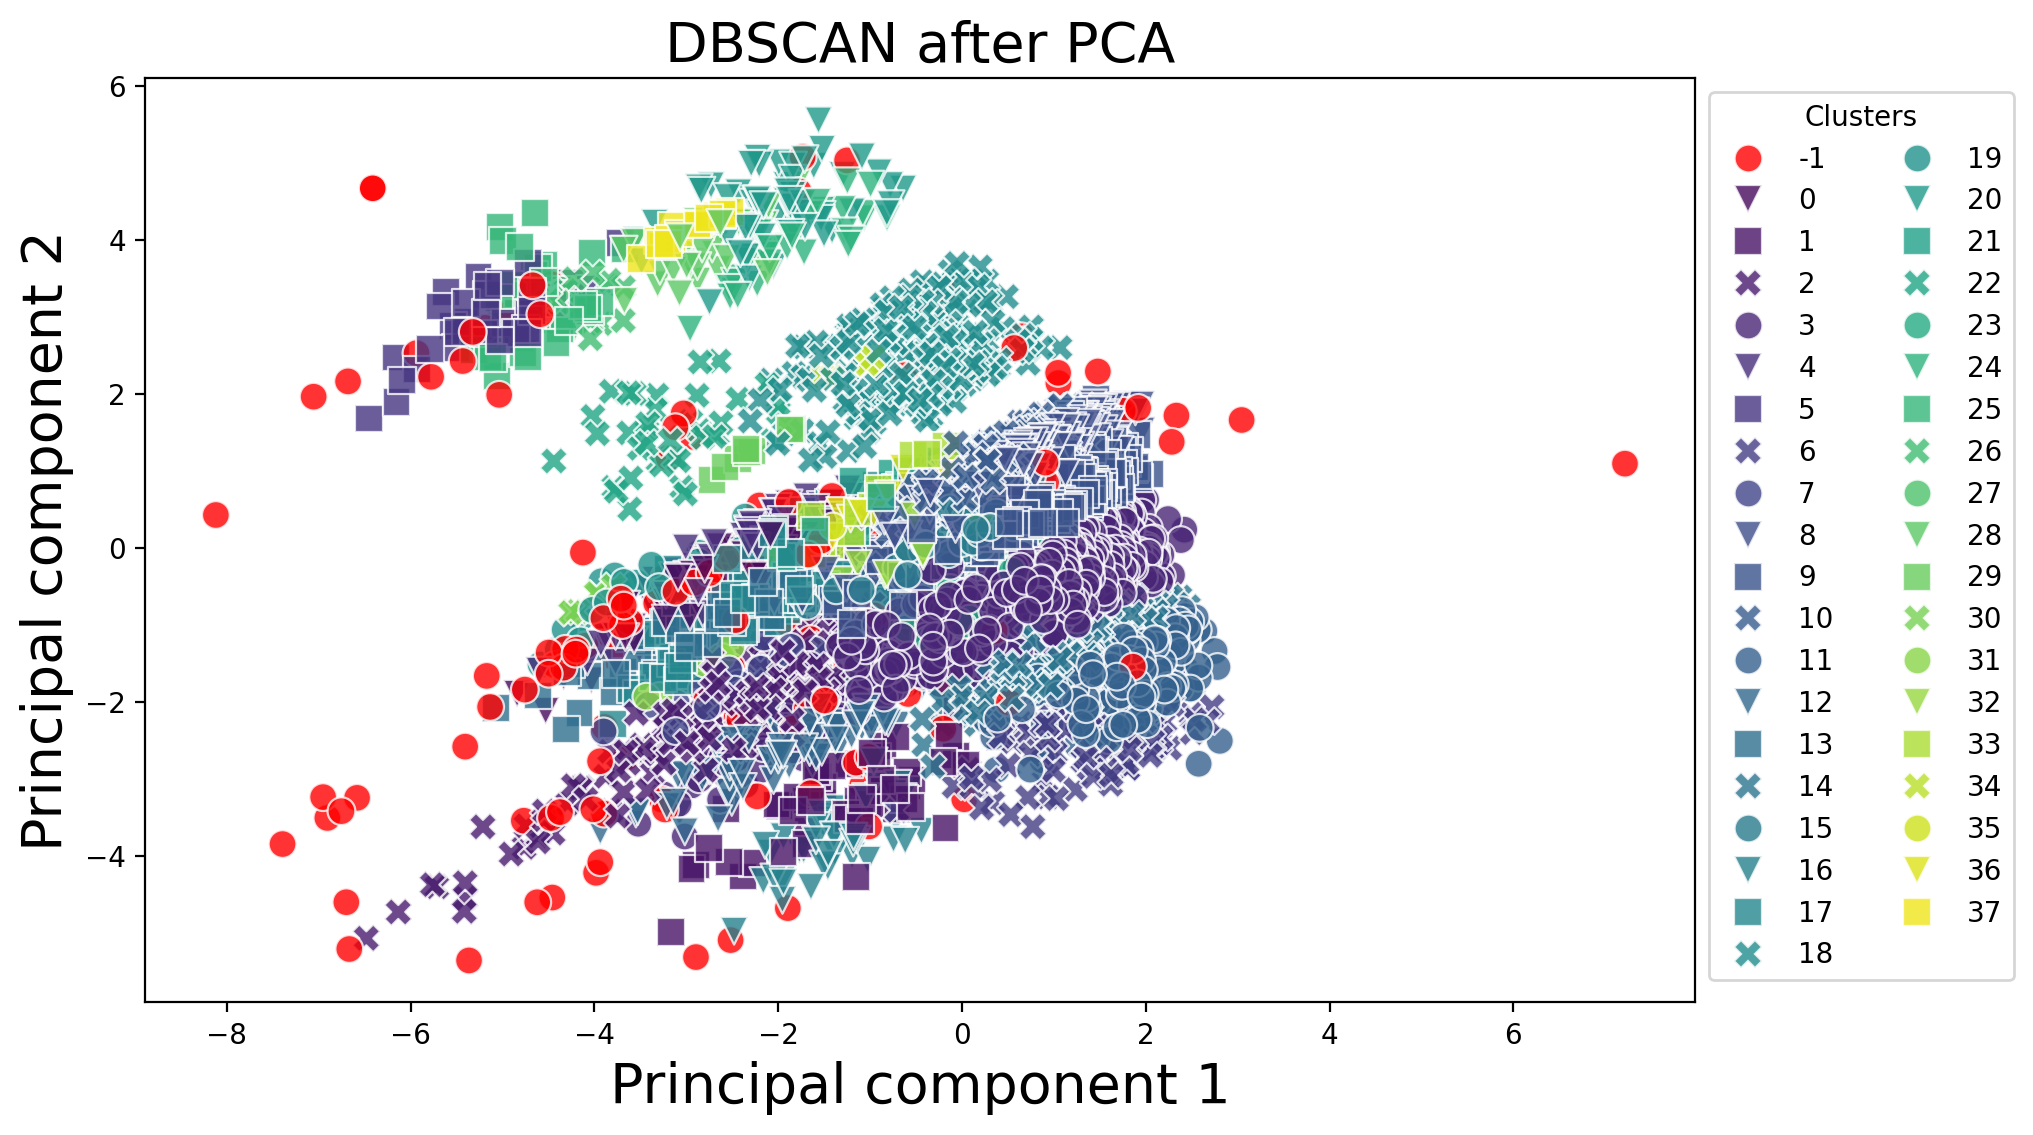

In [40]:
custom_palette = ['red'] + sns.color_palette('viridis', n_colors = n_clusters_dbscan)

plt.figure(figsize = (10, 6), dpi = 200)
sns.scatterplot(data = x_pca_dbscan_df, x = 'x', y = 'y', hue = 'label', style = 'label', palette = custom_palette,
    markers = ['o', 'v', 's', 'X'], alpha = 0.8, s = 100, legend = 'full')
plt.title('DBSCAN after PCA', fontsize = 20)
plt.xlabel('Principal component 1', fontsize = 20)
plt.ylabel('Principal component 2', fontsize = 20)
plt.legend(title = 'Clusters', bbox_to_anchor = (1, 1), ncol = 2)
#plt.savefig('figure/pca_dbscan.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 3.4 T-Distributed Stochastic Neighbor Embedding (TSNE) + DBSCAN

In [41]:
tsne = TSNE(n_components = 2, init = 'random')
x_TSNE = tsne.fit_transform(x)

In [42]:
dbscan.fit(x_TSNE)

DBSCAN(eps=2)

In [43]:
n_clusters_dbscan = len(set(dbscan.labels_) - set([-1]))
n_noise_dbscan = (dbscan.labels_ == -1).sum()
print(f'DBSCAN: {n_clusters_dbscan} clusters, {n_noise_dbscan} points of noise ({100 * n_noise_dbscan / len(dbscan.labels_)}%).')

DBSCAN: 61 clusters, 47 points of noise (0.750558926860428%).


In [44]:
x_TSNE_df = pd.DataFrame(x_TSNE, columns = ['x', 'y'])
x_TSNE_df['label'] = dbscan.labels_

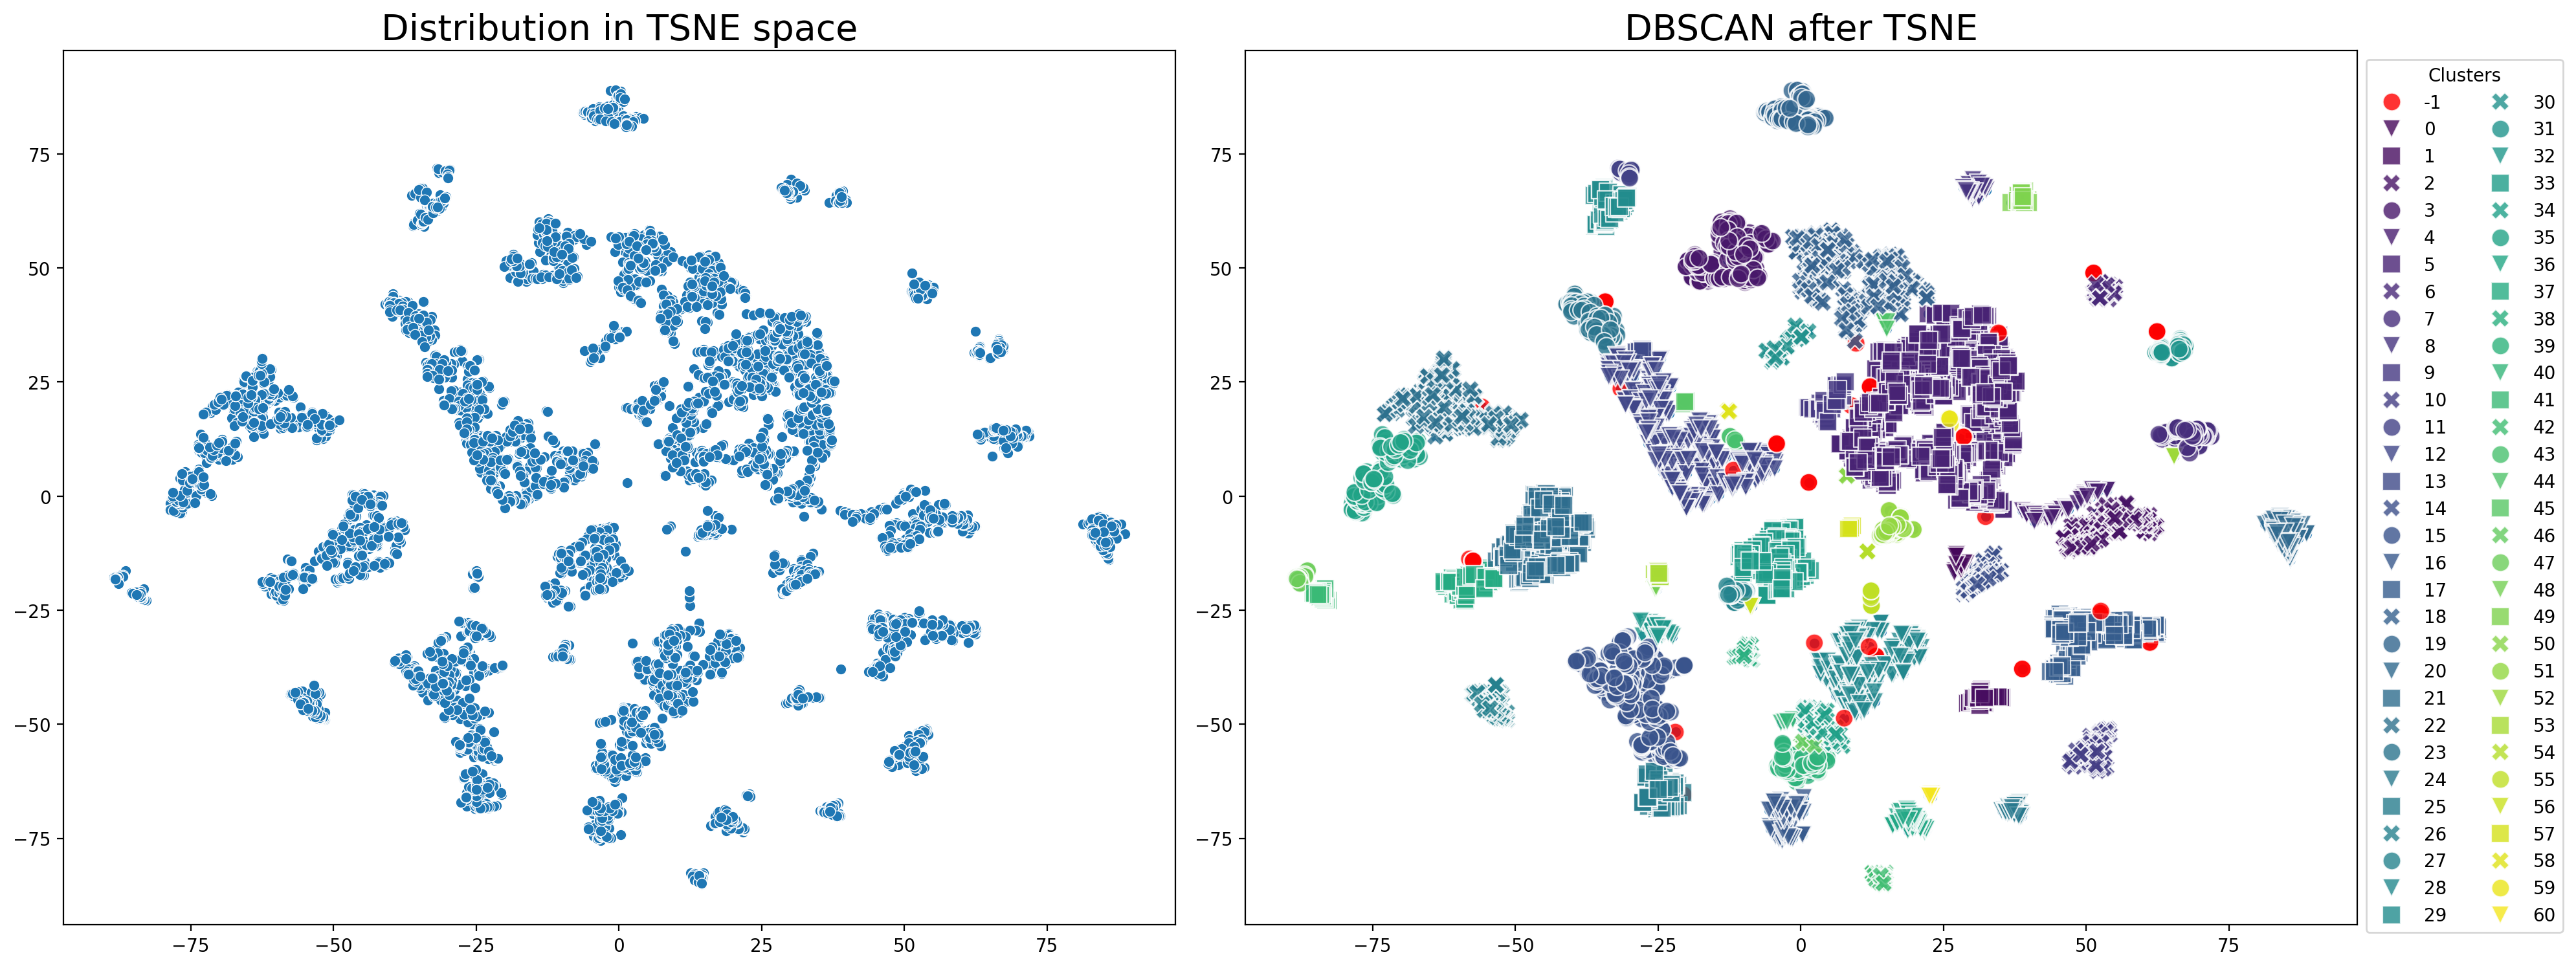

In [45]:
custom_palette = ['red'] + sns.color_palette('viridis', n_colors = n_clusters_dbscan)

plt.figure(figsize = (20, 8), dpi = 200)
plt.subplot(121)
plt.title('Distribution in TSNE space', fontsize = 20)
sns.scatterplot(data = x_TSNE_df, x = 'x', y = 'y')
plt.xlabel('')
plt.ylabel('')
plt.subplot(122)
plt.title('DBSCAN after TSNE', fontsize = 20)
sns.scatterplot(data = x_TSNE_df, x = 'x', y = 'y')
sns.scatterplot(data = x_TSNE_df, x = 'x', y = 'y', hue = 'label', style = 'label', palette = custom_palette,
    markers = ['o', 'v', 's', 'X'], alpha = 0.8, s = 100, legend = 'full')
plt.legend(title = 'Clusters', bbox_to_anchor = (1, 1), ncol = 2)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
#plt.savefig('figure/tsne_dbscan.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()